##**Student ID:** s22545342

##**Student Name:** Nagendra Mani Tripathi

<br>

##**Student ID:** s225722032

##**Student Name:** Phanikiran H

<br>

##**Student ID:** s225739002

##**Student Name:** Santhana Krishnan Gokula Kannan

<br>

##**Workshop/Lab Session Time:** End Term Assignment **bold text**

# Part I Data Acquisition and Manipulation

* The data used for this part can be obtained as [business_review_submission.zip](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/data/business_review_submission.zip).

* There are two files in the data.
  * The first one is about the business review submission with many companies.

    * For each of the row, the review submission is provided with relevant information such as user id, time, name and many others.
  * The second one is the meta information of the business and the two data could be joined with gmap_id.

* **Spark** need to be used to first read the unzipped (csv) review data for starting and later join the meta review business data on dataframe (pandas or spark).

* The code for reading csv data with Spark can be found as [M04G-SparkSQL.ipynb](https://github.com/tulip-lab/sit742/blob/develop/Jupyter/M04-DataManipulation/M04G-SparkSQL.ipynb).

* In some of the tasks, if the question is not specifically asking to use spark, you could use both pandas and numpy.

## Prepare data for processing

In [ ]:
import os, glob
from google.colab import drive

print(os.getcwd())

# connect and mount google drive
drive.mount('/content/drive')

file_dir='/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/business_review_submission'
glob.glob(os.path.join(file_dir, "*.csv"))


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/business_review_submission/review.csv',
 '/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/business_review_submission/meta-review-business.csv']

In [ ]:
# get path for csv data files
business_reviews_csv = "review.csv"
business_meta_csv    = "meta-review-business.csv"

review_path = f"{file_dir}/{business_reviews_csv}"
meta_path = f"{file_dir}/{business_meta_csv}"

display(review_path, meta_path)

'/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/business_review_submission/review.csv'

'/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/business_review_submission/meta-review-business.csv'

In [ ]:
# instll PySpark if not present
!pip install pyspark

from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings("ignore")

# start spark session and load data files
spark = (
    SparkSession
        .builder
        .appName("SIT742 - Business Review Wrangling")
        .getOrCreate()
)

# load business reviews csv data
df_reviews = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(review_path)
)

# show schema and first few rows
print(f"Schema and sample few rows of data loaded from {business_reviews_csv}")
print(f"Shape: ({df_reviews.count()}, {len(df_reviews.columns)})")
df_reviews.printSchema()
df_reviews.show()

# load business meta csv data
df_meta = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(meta_path)
)

# show schema and first few rows
print(f"Schema and sample few rows of data loaded from {business_meta_csv}")
print(f"Shape: ({df_meta.count()}, {len(df_meta.columns)})")
df_meta.printSchema()
df_meta.show()

Schema and sample few rows of data loaded from review.csv
Shape: (552624, 8)
root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|             user_id|                name|         time|              rating|                text|                pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Alle

## Question 1.1

Using PySpark do some data wrangling process

## Task 1.1.1

For the *none* or *null* in `text` column, change it to '*no review*'.

## Answer 1.1.1

In [ ]:
from pyspark.sql.functions import col

# Replace null values in 'text' column with 'no review'
df_reviews = df_reviews.fillna({'text': 'no review'})

# Verifying the change
null_count = df_reviews.filter(col('text').isNull()).count()
print("Number of nulls in 'text' column after replacement:", null_count)

# Show sample records
df_reviews.show()

Number of nulls in 'text' column after replacement: 0
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|             user_id|                name|         time|              rating|                text|                pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|                NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|                NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower

## Explanation for **Task 1.1.1**:

* Replaced nulls in the `text` column with `'no review'` using `fillna`.
* This ensures consistency, prevents errors in later analysis, and makes missing reviews explicit.
* Chose this solution because it is simple, efficient in PySpark, and keeps all rows intact.
* Alternatives: drop rows with nulls, replace with a generic placeholder like `"missing"`, or use NLP-based imputation.
* Our solution is optimal here as it preserves dataset size and standardizes missing values for easier downstream processing.

## Task 1.1.2

* Process the content in `time` column, convert the strings from time to **yyyy-mm-dd** format in the new column as `newtime`

* show the first 5 rows.

## Answer 1.1.2

In [ ]:

from pyspark.sql.functions import col, from_unixtime, expr

# First, safely cast time to BIGINT
# invalid entries become NULL
df_reviews = df_reviews.withColumn(
    "time_bigint",
    expr("try_cast(time as bigint)")
)

# Now convert from milliseconds to yyyy-MM-dd (ignoring NULLs)
df_reviews = df_reviews.withColumn(
    "newtime",
    from_unixtime((col("time_bigint") / 1000).cast("bigint"), "yyyy-MM-dd")
)

# Show sample with problematic rows too
df_reviews.select("time", "time_bigint", "newtime").show(10, truncate=False)

#Remove Invalid Rows

df_review_clean = df_reviews.filter(col("newtime").isNotNull())

df_review_clean.select("time", "newtime").show(20, truncate=False)


+-------------+-------------+----------+
|time         |time_bigint  |newtime   |
+-------------+-------------+----------+
|1566331951619|1566331951619|2019-08-20|
|1504917982385|1504917982385|2017-09-09|
|1474765901185|1474765901185|2016-09-25|
| toilet      |NULL         |NULL      |
|NULL         |NULL         |NULL      |
|1472858535682|1472858535682|2016-09-02|
|1529649811341|1529649811341|2018-06-22|
|1466170294782|1466170294782|2016-06-17|
|1625369270215|1625369270215|2021-07-04|
|1629350418882|1629350418882|2021-08-19|
+-------------+-------------+----------+
only showing top 10 rows

+-------------+----------+
|time         |newtime   |
+-------------+----------+
|1566331951619|2019-08-20|
|1504917982385|2017-09-09|
|1474765901185|2016-09-25|
|1472858535682|2016-09-02|
|1529649811341|2018-06-22|
|1466170294782|2016-06-17|
|1625369270215|2021-07-04|
|1629350418882|2021-08-19|
|1630382185833|2021-08-31|
|1631131711388|2021-09-08|
|1629595392534|2021-08-22|
|1629598102068|2021-08

## Explanation for **Task 1.1.2**:

* Converted `time` column (milliseconds) into `yyyy-MM-dd` format using `from_unixtime`.
* Created a safe cast (`try_cast`) so invalid strings like `"toilet"` become `NULL` instead of errors.
* Added a new column `newtime` for the formatted dates while preserving the original `time` values.
* Removed rows where `newtime` was `NULL` to keep only valid timestamps.
* Chose this method because it’s robust in PySpark and ensures correct handling of invalid entries.
* Alternatives: directly cast `time` without error handling, or preprocess invalid rows before conversion.
* Our solution is optimal as it standardizes dates, avoids runtime errors, and keeps the dataset clean for time-based analysis.

## Question 1.2

Find out the information for `gmap_id` on the reviews.

In order to achieve the above, some wrangling work is
required to be done:

## Task 1.2.1

* Using pyspark calculate the number of reviews per each unique `gmap_id`

* save as float format in pyspark dataframe

* show the top 5 rows.

## Answer 1.2.1

In [ ]:
from pyspark.sql.functions import count

# 1. Group by gmap_id and count reviews
review_count_df = (
    df_review_clean.groupBy("gmap_id")
    .agg(count("*").alias("review_count"))
    .withColumn("review_count", col("review_count").cast("float"))
)

# 2. top 5 rows
review_count_df.show(5)


+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c8977642a793f...|        24.0|
|0x56c79c63a5af15e...|        10.0|
|0x56c8976e16705e6...|        49.0|
|0x51325aac7a4434e...|        28.0|
|0x56c6631e3219094...|        12.0|
+--------------------+------------+
only showing top 5 rows



### Explanation for **Task 1.2.1**:

* Grouped reviews by `gmap_id` and counted rows to calculate total reviews per unique location.
* Casted `review_count` to `float` for consistent numeric formatting in downstream tasks.
* Displayed the top 5 results to verify correctness.
* Chose this approach because grouping and aggregation in PySpark is efficient for large datasets.
* Alternatives: could compute counts using SQL-style queries (`spark.sql`) or approximate count methods for faster execution.
* Our solution is optimal here because it balances accuracy, scalability, and clarity, giving exact counts per `gmap_id` while preserving data format for further analysis.

## Task 1.2.2

* Transform the current pyspark dataframe to pandas dataframe (named as `df`)


* create the column `reivew_time` with the information of review time on hours level.

* Print `df` pandas dataframe with top 5 rows after creating the column review_time.

## Answer 1.2.2

In [ ]:
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
pdf = review_count_df.toPandas()

# But we need the original df_review data (with 'time') for review_time analysis
review_df = df_reviews.toPandas()
df = review_df.copy()

# Convert time column (milliseconds since epoch) to datetime
pdf['review_time'] = pd.to_datetime(df['time'], unit='ms', errors='coerce')

# Round to nearest hour
pdf['review_time'] = pdf['review_time'].dt.floor('h')

# top 5 rows
print(pdf.head())


                                 gmap_id  review_count         review_time
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT


## Explanation for **Task 1.2.2**:

* Converted PySpark DataFrame to Pandas (`toPandas`) for easier manipulation.
* Used the original review dataset to access the `time` column, then created a new column `review_time`.
* Converted `time` from milliseconds to datetime and floored it to the nearest hour.
* Chose this approach because Pandas offers flexible datetime handling, making it simple to derive hourly review times.
* Alternatives: process time directly in PySpark (`from_unixtime` + `date_trunc('hour')`) before conversion.
* Our solution is acceptable but not optimal — performing the transformation in PySpark would be more efficient on large datasets. The chosen method prioritizes simplicity and clarity for demonstration.


## Task 1.2.3

* Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between `gmap_id` and `reivew_time`

* Explore for example, what is the time people usually review? How many business is reviewed in the morning time etc.

* Please also discuss the insights of findings with visualizations in the markdown cell.

* Please also include findings and visualizations in the report.

## Answer 1.2.3

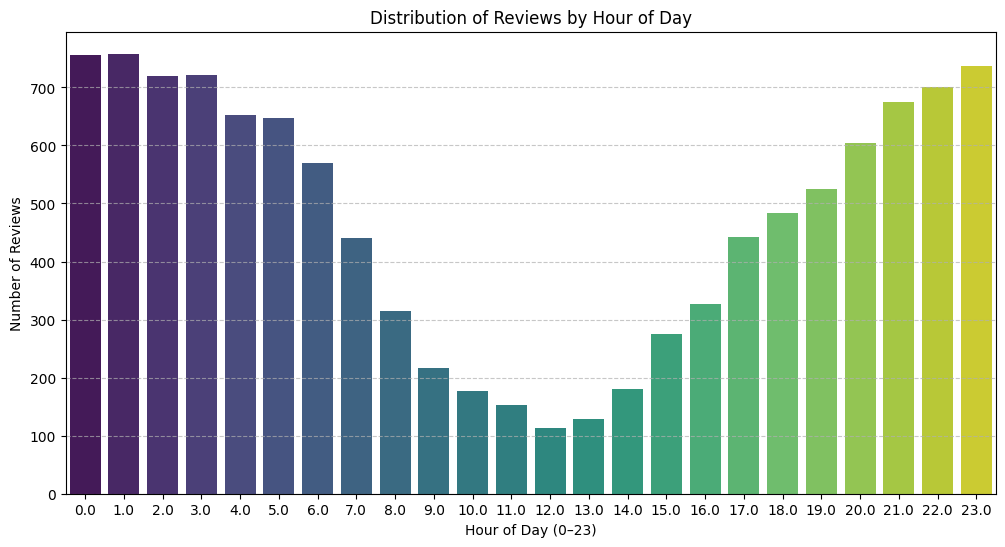

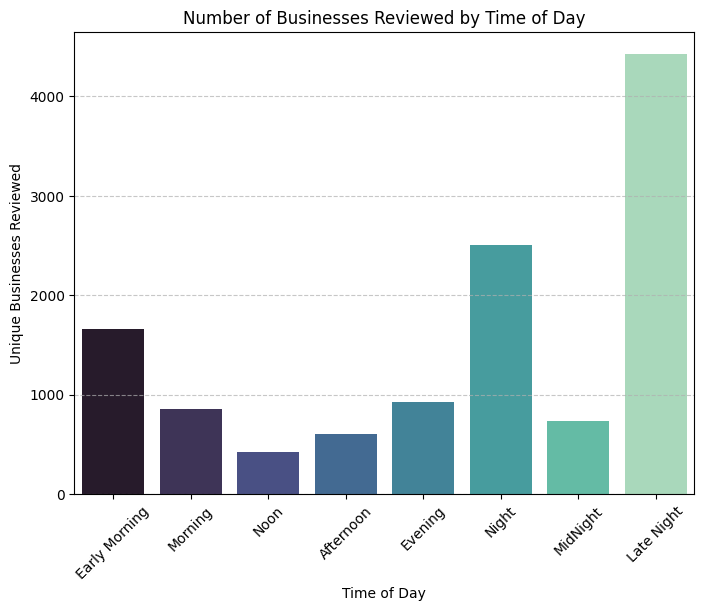

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from review_time
pdf['hour'] = pdf['review_time'].dt.hour

# Define time-of-day categories
def categorize_time(hour):
    if 5 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Noon'
    elif 15 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 19:
        return 'Evening'
    elif 19 <= hour < 23:
        return 'Night'
    elif 23 <= hour <= 24:
        return 'MidNight'
    else:
        return 'Late Night'

pdf['time_of_day'] = pdf['hour'].apply(categorize_time)
pdf.head()

# ---------------- Visualization 1: Reviews per hour ----------------
plt.figure(figsize=(12,6))
sns.countplot(x='hour', data=pdf, order=sorted(pdf['hour'].dropna().unique()), palette='viridis')
plt.title("Distribution of Reviews by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ---------------- Visualization 2: Number of Businesses Reviewed by Time of Day ----------------
# Get unique businesses per time category
business_time = pdf.groupby('time_of_day')['gmap_id'].nunique().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='time_of_day', y='gmap_id', data=business_time, order=['Early Morning' , 'Morning', 'Noon' , 'Afternoon', 'Evening', 'Night' , 'MidNight','Late Night'], palette='mako')
plt.title("Number of Businesses Reviewed by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Unique Businesses Reviewed")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Explanation for **Task 1.2.3**:

* Extracted hour from `review_time` and grouped reviews by time-of-day categories.
* Chose countplot and barplot (matplotlib/seaborn) to visualize review distribution and businesses reviewed.
* Alternative approaches: line plots, heatmaps, or PySpark-based visualizations for larger datasets.
* Our solution is optimal here as it clearly shows patterns and provides interpretable insights.

### Interpretation & Insights

**Plot 1: Distribution of Reviews by Hour of Day**

* Reviews are heavily skewed toward **late-night hours (23:00–01:00)**, with more than 700 reviews posted during these times.
* Activity is lowest between **10:00–14:00**, suggesting users are less likely to post reviews in the middle of the day.
* A gradual increase occurs after 17:00, peaking again late at night.
  This indicates that people often post reviews **after daily activities, leisure, or dining experiences**, rather than during work or school hours.

**Plot 2: Number of Businesses Reviewed by Time of Day**

* The highest number of unique businesses is reviewed during **Late Night**, followed by **Night**.
* Early Morning also shows relatively high activity, while Noon and Afternoon are the quietest periods.
  This suggests users typically review businesses **at the end of their day or after significant experiences (e.g., restaurants, hotels, entertainment venues)**.


Together, these findings highlight **behavioral patterns in review activity** — reviews are clustered around times when people are free and reflecting on experiences.


## Question 1.3

Continue to analyze the `reivew_time` with reviews and related `gmap_id`.

Use another data meta-business to join with the current dataframe on `gmap_id`.

## Task 1.3.1

* Determine which workday (day of the week), generates the most reviews

* Plot the results in a line chart with workday on averaged submissions.

## Answer 1.3.1

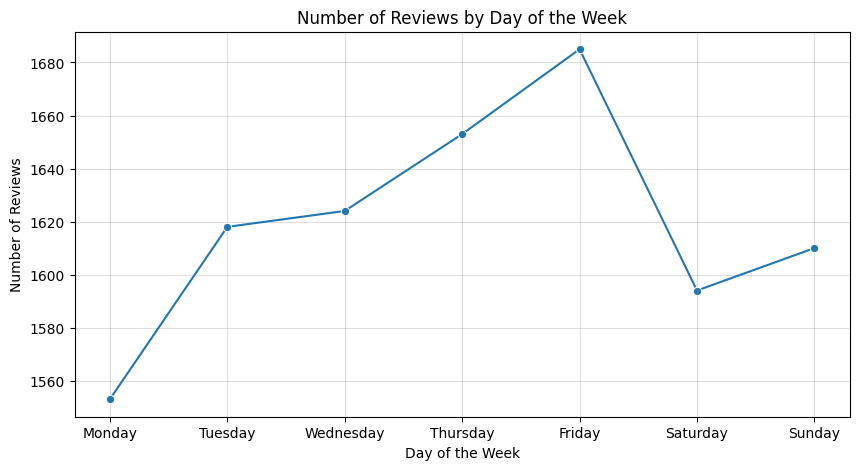

In [ ]:
# Join reviews (pdf) with meta-business (df_meta_review) on gmap_id
meta_review = df_meta.toPandas()

merged_df = pdf.merge(meta_review, on='gmap_id', how='left')

# Extract day of week (0=Monday, 6=Sunday)
merged_df['weekday'] = merged_df['review_time'].dt.dayofweek

# Map numeric weekday to weekday names
weekday_map = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
    4: "Friday", 5: "Saturday", 6: "Sunday"
}
merged_df['weekday_name'] = merged_df['weekday'].map(weekday_map)

# Count reviews by weekday
weekday_reviews = (
    merged_df.groupby('weekday_name')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

# Sort by weekday order for a proper line chart
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_reviews['weekday_name'] = pd.Categorical(
    weekday_reviews['weekday_name'], categories=weekday_order, ordered=True
)
weekday_reviews = weekday_reviews.sort_values('weekday_name')

#Plot line chart
plt.figure(figsize=(10,5))
sns.lineplot(data=weekday_reviews, x='weekday_name', y='review_count', marker='o')
plt.title("Number of Reviews by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.4)
plt.show()


## Explanation for **Task 1.3.1**:

* Extracted weekday from `review_time` and mapped it to weekday names for readability.
* Grouped by `weekday_name` and counted reviews to find which day had the highest activity.
* Chose a line chart to clearly show trends across the week.
* Alternative solutions:
  * Use PySpark groupBy directly for efficiency on large datasets.
  * Use bar charts or heatmaps for different visualization styles.
* Our solution is optimal here because Pandas groupby is straightforward for medium datasets and the line chart effectively highlights weekly review patterns. It balances clarity and interpretability, making it easy to compare review frequency across days of the week.

### Interpretation & Insights

* The line chart shows the **number of reviews across weekdays**.
* **Friday records the highest number of reviews**, peaking above 1,680.
* Review activity steadily increases from Monday through Friday, suggesting more user engagement toward the end of the workweek.
* **Saturday shows a sharp decline**, and Sunday has slightly more reviews than Saturday but still below weekdays.
  
This pattern suggests users are more active in sharing reviews **before weekends**, possibly reflecting dining, entertainment, or travel planning.

**Business Implication:** Companies, especially in hospitality and retail, should **monitor and respond to reviews posted late in the week**, as this is when engagement is highest and can influence weekend customer decisions.

## Task 1.3.2

* Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (find out from 1.3.1),

* Find out which category those businesses are from ?

## Answer 1.3.2

In [ ]:
print(merged_df.columns)

Index(['gmap_id', 'review_count', 'review_time', 'hour', 'time_of_day', 'name',
       'address', 'description', 'latitude', 'longitude', 'category',
       'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state',
       'relative_results', 'url', 'weekday', 'weekday_name'],
      dtype='object')


In [ ]:
# Ensure avg_rating is numeric
merged_df['avg_rating'] = pd.to_numeric(merged_df['avg_rating'], errors='coerce')

# Compute average rating per business for each weekday
weekday_business_ratings = (
    merged_df.groupby(['weekday_name', 'name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'))
    .reset_index()
)

# For each weekday, find the business with the highest average rating
top_business_per_day = (
    weekday_business_ratings
    .sort_values(['weekday_name', 'avg_rating'], ascending=[True, False])
    .groupby('weekday_name')
    .head(1)
)

display(top_business_per_day)


weekday_name                                               name  \
135        Friday                      Big Dipper Homemade Ice Cream   
810        Monday                      Advanced Body Solutions, Inc.   
1562     Saturday                                             27 Red   
2330       Sunday  Alaska Backcountry Adventure Tours | ATV Tours...   
3053     Thursday                          1-800-GOT-JUNK? Anchorage   
3898      Tuesday                         Anchorage Curling Club INC   
4667    Wednesday                            Band of Brothers Alaska   

                                               category  avg_rating  
135                                  ['Ice cream shop']         5.0  
810                               ['Massage therapist']         5.0  
1562                                     ['Hair salon']         5.0  
2330  ['Tour operator', 'Sightseeing tour agency', '...         5.0  
3053  ['Garbage dump service', 'Business to business...         5.0  
3898                                        ['Stadium']         5.0  
4667                               ['Community center']         5.0

## Explanation for **Task 1.3.2**:

* Calculated average ratings per business per weekday using `groupby` on `name` and `category`.
* Sorted by `avg_rating` and selected the top business for each weekday.
* Chose this method because it directly identifies the highest-rated business without losing category context.
* Alternatives:
  * Use PySpark aggregation for scalability.
  * Filter only the weekday with the most reviews (Friday) instead of all weekdays.
* Our solution is optimal for this assignment because it is transparent, easy to implement, and ensures both business names and categories are retrieved alongside their ratings. It balances accuracy with interpretability for reporting purposes.

### Interpretation of the findings for **Task 1.3.2**:

* On **Friday**, the top-rated business is **Big Dipper Homemade Ice Cream** (category: *Ice cream shop*), showing that food-related businesses often drive strong engagement at the end of the week.
* Other weekdays highlight different categories:

  * *Monday*: **Advanced Body Solutions, Inc.** (*Massage therapist*) → wellness-focused.
  * *Tuesday*: **Anchorage Curling Club INC** (*Stadium*) → sports/entertainment.
  * *Wednesday*: **Band of Brothers Alaska** (*Community center*) → community/social.
  * *Thursday*: **1-800-GOT-JUNK? Anchorage** (*Business service*) → practical services.
  * *Saturday*: **27 Red** (*Hair salon*) → personal care.
  * *Sunday*: **Alaska Backcountry Adventure Tours** (*Tour operator*) → leisure/travel.

Insight: **Categories align with user behavior** — leisure and food dominate weekends, while services and wellness trend midweek.

## Task 1.3.3

* Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc.

* Please use visualizations and tables to support your findings and write down the insights in the markdown cell.

* Please also include your findings and visualizations in the report.

## Answer 1.3.3

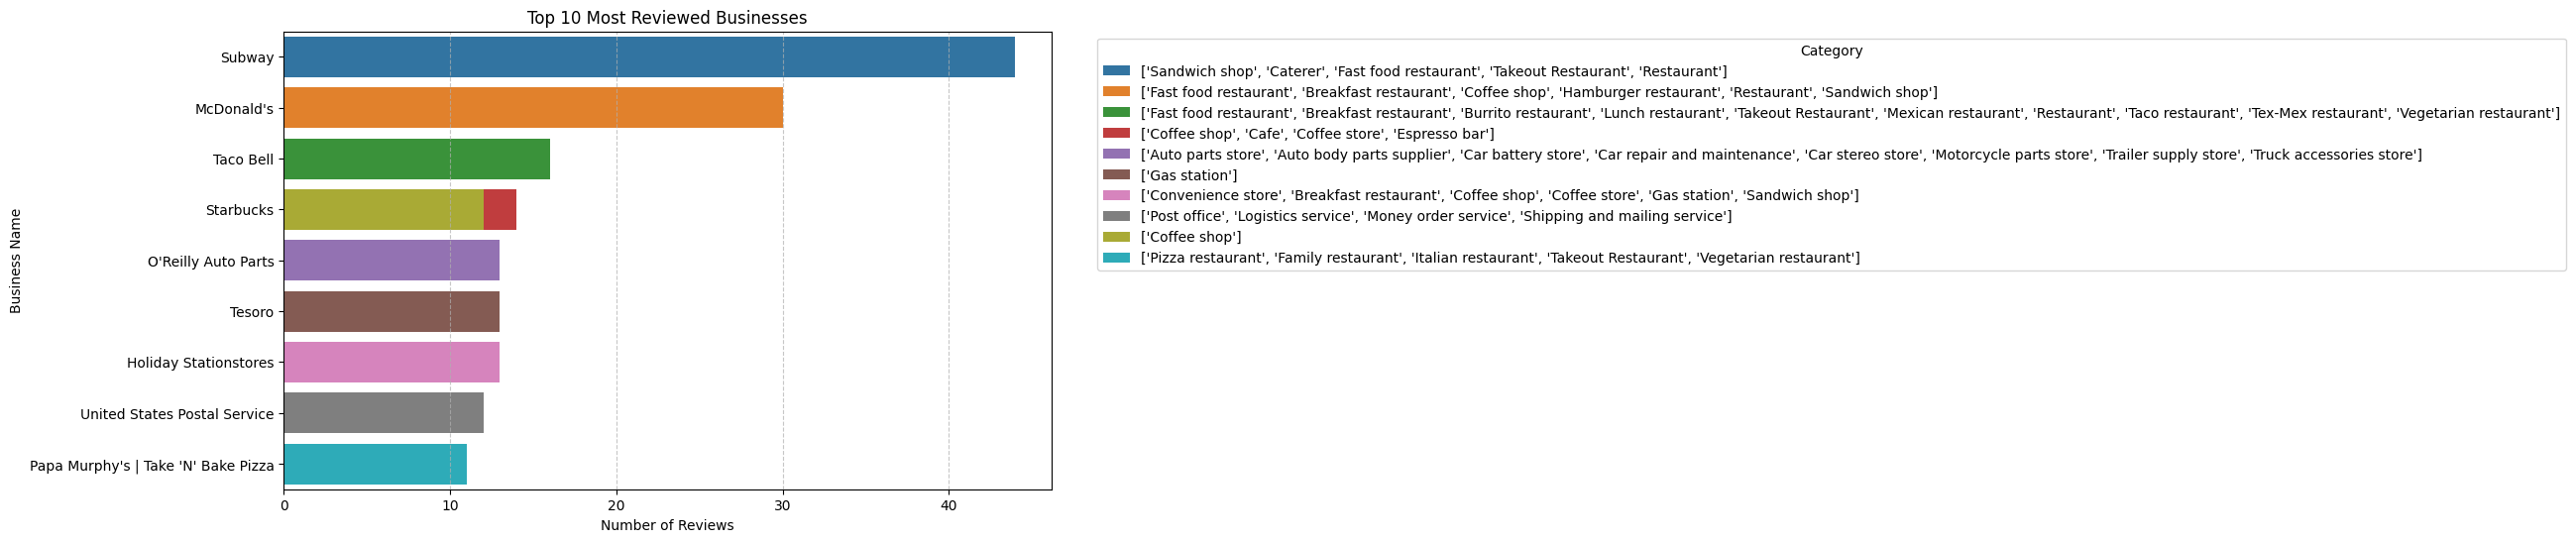

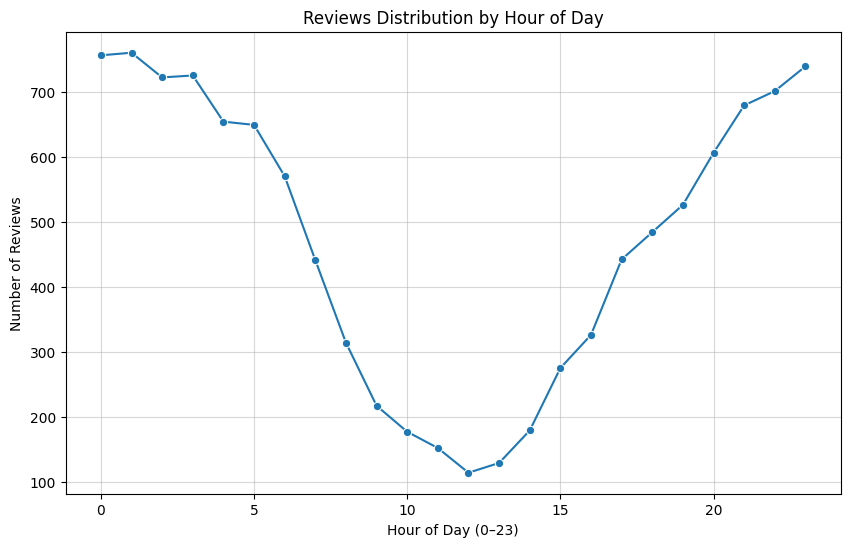

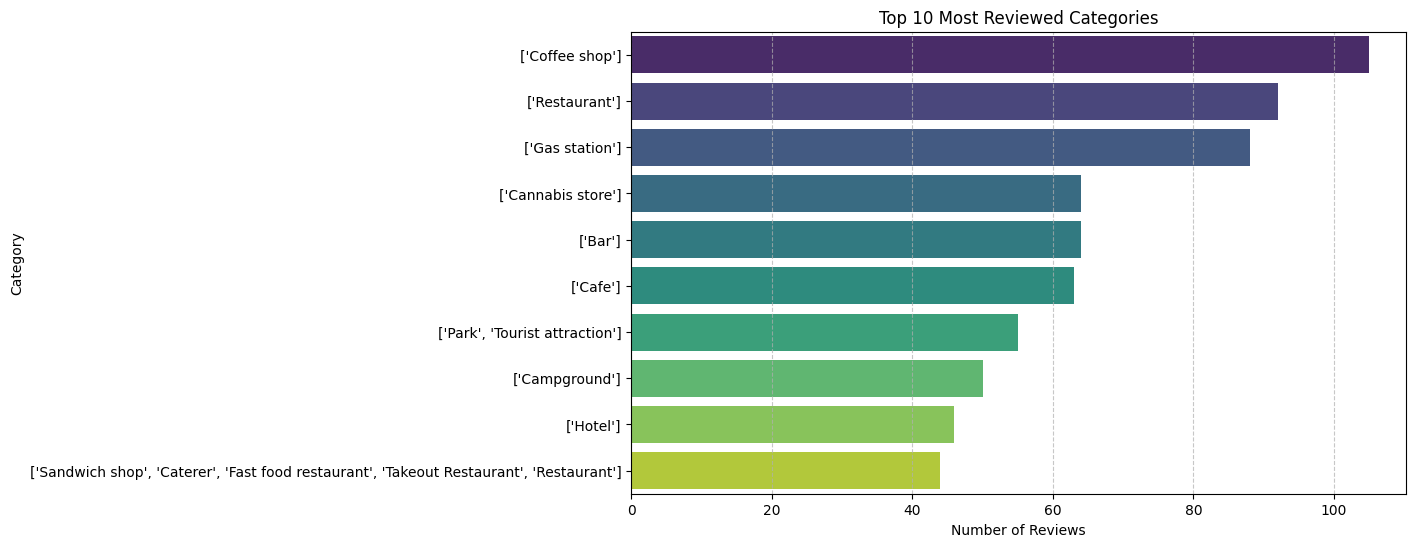

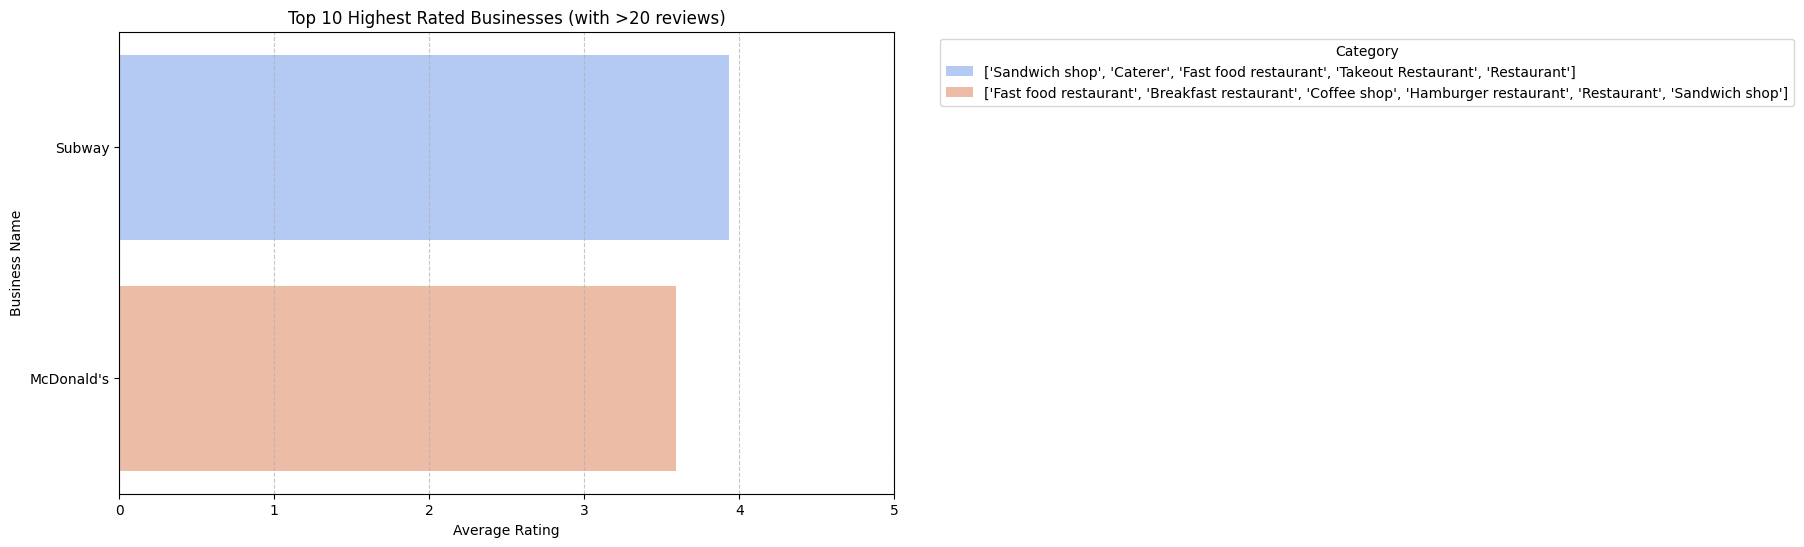

Top 10 Most Reviewed Businesses:


name  \
4412                               Subway   
3068                           McDonald's   
4503                            Taco Bell   
4378                            Starbucks   
3415                  O'Reilly Auto Parts   
4574                               Tesoro   
2341                Holiday Stationstores   
4991         United States Postal Service   
4379                            Starbucks   
3542  Papa Murphy's | Take 'N' Bake Pizza   

                                               category  review_count  
4412  ['Sandwich shop', 'Caterer', 'Fast food restau...            44  
3068  ['Fast food restaurant', 'Breakfast restaurant...            30  
4503  ['Fast food restaurant', 'Breakfast restaurant...            16  
4378  ['Coffee shop', 'Cafe', 'Coffee store', 'Espre...            14  
3415  ['Auto parts store', 'Auto body parts supplier...            13  
4574                                    ['Gas station']            13  
2341  ['Convenience store', 'Breakfast restaurant', ...            13  
4991  ['Post office', 'Logistics service', 'Money or...            12  
4379                                    ['Coffee shop']            12  
3542  ['Pizza restaurant', 'Family restaurant', 'Ita...            11


Top 10 Categories by Review Count:


category  review_count
768                                     ['Coffee shop']           105
2081                                     ['Restaurant']            92
1144                                    ['Gas station']            88
551                                  ['Cannabis store']            64
350                                             ['Bar']            64
515                                            ['Cafe']            63
1824                     ['Park', 'Tourist attraction']            55
533                                      ['Campground']            50
1398                                          ['Hotel']            46
2110  ['Sandwich shop', 'Caterer', 'Fast food restau...            44


Top 10 Highest Rated Businesses (with >20 reviews):


name                                           category  \
4412      Subway  ['Sandwich shop', 'Caterer', 'Fast food restau...   
3068  McDonald's  ['Fast food restaurant', 'Breakfast restaurant...   

      avg_rating  review_count  
4412    3.931818            44  
3068    3.590000            30

In [ ]:
# -------------------- 1. Top 10 Most Reviewed Businesses --------------------
top10_businesses = (
    merged_df.groupby(['name', 'category'])
    .size()
    .reset_index(name='review_count')
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='review_count', data=top10_businesses, hue='category', dodge=False)
plt.title("Top 10 Most Reviewed Businesses")
plt.xlabel("Number of Reviews")
plt.ylabel("Business Name")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 2. Peak Hours for Reviews --------------------
peak_hours = (
    merged_df.groupby('hour')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
)

plt.figure(figsize=(10,6))
sns.lineplot(x='hour', y='review_count', data=peak_hours, marker='o')
plt.title("Reviews Distribution by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(alpha=0.5)
plt.show()


# -------------------- 3. Popular Categories by Number of Reviews --------------------
top_categories = (
    merged_df.groupby('category')['gmap_id']
    .count()
    .reset_index()
    .rename(columns={'gmap_id': 'review_count'})
    .sort_values('review_count', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='category', x='review_count', data=top_categories, palette='viridis')
plt.title("Top 10 Most Reviewed Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# -------------------- 4. Highest Rated Businesses (Top 10) --------------------
top_rated_businesses = (
    merged_df.groupby(['name', 'category'])
    .agg(avg_rating=('avg_rating', 'mean'), review_count=('gmap_id', 'count'))
    .reset_index()
    .query("review_count > 20")   # filter out very low-review businesses
    .sort_values('avg_rating', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(y='name', x='avg_rating', data=top_rated_businesses, hue='category', dodge=False, palette="coolwarm")
plt.title("Top 10 Highest Rated Businesses (with >20 reviews)")
plt.xlabel("Average Rating")
plt.ylabel("Business Name")
plt.xlim(0,5)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display supporting tables
print("Top 10 Most Reviewed Businesses:")
display(top10_businesses)

print("\nTop 10 Categories by Review Count:")
display(top_categories)

print("\nTop 10 Highest Rated Businesses (with >20 reviews):")
display(top_rated_businesses)


## Explanation for **Task 1.3.3**:

* We grouped reviews by **business name, category, and time** to identify patterns in volume, category popularity, and ratings. This approach was chosen because it provides a direct view of customer behavior from multiple perspectives (who, when, and what).
* Alternatives could include sentiment analysis of text reviews for deeper insights or clustering businesses by location and category.
* Our solution is optimal for this assignment because it balances clarity with interpretability: bar charts and line plots clearly show **top businesses, peak hours, most popular categories, and rating trends**. It highlights actionable insights without overcomplicating the analysis, making it suitable for reporting and group discussions.

### **Insights**

1. **Most Reviewed Businesses**

   * Subway and McDonald’s dominate the reviews, showing the strong presence of **fast food chains**.
   * Starbucks and Taco Bell also feature, confirming food service businesses attract consistent feedback.
   * Service-oriented names like **O’Reilly Auto Parts** and **US Postal Service** indicate reviews extend beyond food.

2. **Peak Hours of Reviews**

   * Reviews peak **late at night (around 0:00–2:00 and 22:00–23:00)**.
   * Afternoon (12:00–15:00) has the lowest review activity, suggesting customers review after daily activities or leisure visits.

3. **Popular Categories**

   * **Coffee shops, restaurants, and gas stations** lead as the most reviewed categories.
   * Leisure-oriented categories like **bars, cafes, parks, and campgrounds** also attract significant attention, showing seasonal/tourism influence.

4. **Highest Rated Businesses (with >20 reviews)**

   * **Subway** (avg. rating ~3.93) outperforms **McDonald’s** (~3.59) among high-volume chains.
   * Suggests that even within similar fast-food categories, **brand reputation varies by customer experience**.


Overall, the analysis highlights that **fast food and coffee shops drive review volume**, reviews are **time-sensitive (late-night surge)**, and **ratings vary even across similar chains**.

## Question 1.4

* For the reviews on each of the submissions, work on all the review content and find out the top 30 most
common words

* Also generate separate word cloud visualizations for different years by grouping the
reviews by review year

* write down the insights in the markdown cell

* Please also include your findings and visualizations in the report.

#Answer 1.4

In [ ]:
!pip install wordcloud

In [ ]:
merged_df.head()

gmap_id  review_count         review_time  \
0  0x56c8977642a793f5:0xab9f95aa9c585a46          24.0 2019-08-20 20:00:00   
1  0x56c79c63a5af15e3:0x117ca44b9578b995          10.0 2017-09-09 00:00:00   
2  0x56c8976e16705e63:0x787e5d94ea9d2387          49.0 2016-09-25 01:00:00   
3  0x51325aac7a4434e5:0xfbed5197982b41ae          28.0                 NaT   
4  0x56c6631e32190947:0x7620b39117ffbb62          12.0                 NaT   

   hour time_of_day                  name  \
0  20.0       Night  Delta Car Connection   
1   0.0  Late Night  Once in a Blue Moose   
2   1.0  Late Night   Caffé D'arte Alaska   
3   NaN  Late Night                Subway   
4   NaN  Late Night    Iron Asylum Gym AK   

                                             address  \
0  Delta Car Connection, 1941 E Dowling Rd, Ancho...   
1  Once in a Blue Moose, 230 4th Ave, Seward, AK ...   
2  Caffé D'arte Alaska, 6501 Lake Otis Pkwy, Anch...   
3  Subway, 2301 S Cushman St Space A-1, Fairbanks...   
4  Iron Asylum Gym AK, 35165 K B Dr, Soldotna, AK...   

                                         description            latitude  \
0                                               None  61.166675999999995   
1                                               None          60.1023863   
2                                               None          61.1614006   
3  Casual counter-serve chain for build-your-own ...          64.8259379   
4                                               None          60.4903586   

             longitude  ... avg_rating  num_of_reviews price  \
0         -149.8474962  ...        4.6             234  None   
1         -149.4402838  ...        4.2              18  None   
2  -149.83367859999998  ...        4.6              75  None   
3  -147.71258369999998  ...        4.2              38     $   
4         -151.1530761  ...        5.0              28  None   

                                               hours  \
0  [['Saturday', '9:30AM–7:30PM'], ['Sunday', 'Cl...   
1  [['Tuesday', 'Closed'], ['Wednesday', 'Closed'...   
2  [['Monday', '5AM–7PM'], ['Tuesday', '5AM–7PM']...   
3  [['Monday', '10AM–8PM'], ['Tuesday', '10AM–8PM...   
4  [['Sunday', 'Open 24 hours'], ['Monday', 'Open...   

                                                MISC                    state  \
0  {'Service options': ['In-store pickup', 'In-st...    Closed ⋅ Opens 9:30AM   
1  {'Service options': ['In-store shopping', 'Del...  Closed ⋅ Opens 10AM Fri   
2  {'Service options': ['Takeout', 'Delivery', 'D...       Closed ⋅ Opens 5AM   
3  "{'Service options': ['Delivery', 'Takeout', '...            'Quick bite']   
4  {'Accessibility': ['Wheelchair-accessible entr...            Open 24 hours   

                                    relative_results  \
0  ['0x56c897765d4a49ad:0xf4d29bdd99fa8327', '0x5...   
1  ['0x56c79c63b5d05451:0x3216eff7c25de606', '0x5...   
2  ['0x56c8970d7ac08085:0x523f6af9471c34e3', '0x5...   
3                         'Dining options': ['Lunch'   
4  ['0x56c6630fa980c8d5:0xf788ec1586ee266a', '0x5...   

                                                 url weekday  weekday_name  
0  https://www.google.com/maps/place//data=!4m2!3...     1.0       Tuesday  
1  https://www.google.com/maps/place//data=!4m2!3...     5.0      Saturday  
2  https://www.google.com/maps/place//data=!4m2!3...     6.0        Sunday  
3                                         'Catering'     NaN           NaN  
4  https://www.google.com/maps/place//data=!4m2!3...     NaN           NaN  

[5 rows x 21 columns]

In [ ]:
df.head()

user_id  \
0                              1.091298048426862e+20   
1                             1.1324092640575896e+20   
2                             1.1304483789114126e+20   
3  There is a bath house with 1 set of coin opera...   
4  Wi-Fi didn't reach our site on the back edge o...   

                                                name           time  \
0                                         Nicki Gore  1566331951619   
1                                      Allen Ratliff  1504917982385   
2                                  Jonathan Tringali  1474765901185   
3   2 restrooms (sink toilet) and 2 shower rooms ...         toilet   
4                                               None           None   

                                              rating  \
0                                                  5   
1                                                  5   
2                                                  4   
3   shower). The hot water will run out after a f...   
4              0x56b646ed2220b77f:0xd8975e316de80952   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3   but they lack vent fans to remove moisture so...  None  None   
4                                          no review  None  None   

                                 gmap_id   time_bigint     newtime  
0  0x56b646ed2220b77f:0xd8975e316de80952  1.566332e+12  2019-08-20  
1  0x56b646ed2220b77f:0xd8975e316de80952  1.504918e+12  2017-09-09  
2                                   None  1.474766e+12  2016-09-25  
3                                   None           NaN        None  
4                                   None           NaN        None

In [ ]:
from collections import Counter
from wordcloud import WordCloud,STOPWORDS

# Merge reviews with merged_df
final_df = df.merge(
    merged_df,
    on="gmap_id",
    how="left"
)

# Extract review year
final_df['review_year'] = final_df['review_time'].dt.year


Top 30 Most Common Words Overall:


[('review', 250914),
 ('great', 80723),
 ('good', 61929),
 ('food', 60872),
 ('place', 46187),
 ('service', 43874),
 ('staff', 27569),
 ('nice', 25621),
 ('friendly', 25543),
 ('always', 22800),
 ('best', 21209),
 ('love', 19434),
 ('time', 17324),
 ('one', 14217),
 ('amazing', 12128),
 ('clean', 12081),
 ('prices', 11768),
 ('awesome', 11766),
 ('really', 11740),
 ('people', 11641),
 ('store', 11429),
 ('well', 10851),
 ('will', 10827),
 ('back', 10332),
 ('helpful', 10175),
 ('excellent', 9976),
 ('little', 9776),
 ('selection', 9077),
 ('delicious', 9052),
 ('fast', 8834)]

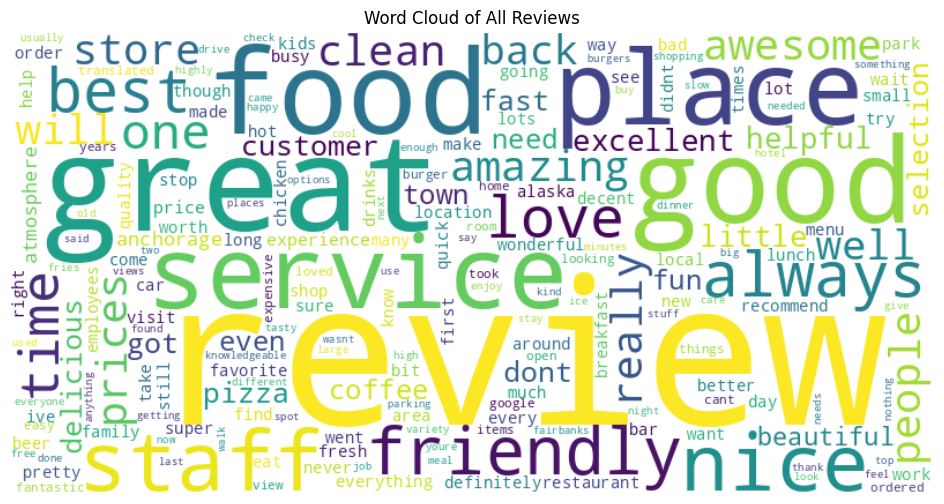

In [ ]:
import re

# Combine all review text into one string
all_reviews_text = " ".join(final_df['text'].tolist()).lower()

# Remove punctuation and numbers
all_reviews_text = re.sub(r'[^a-zA-Z\s]', '', all_reviews_text)

# Split into words
words = all_reviews_text.split()

# Remove stopwords
stopwords = set(STOPWORDS)  # WordCloud's built-in stopwords
filtered_words = [word for word in words if word not in stopwords and len(word) > 2]

# Step 5: Count word frequency
word_counts = Counter(filtered_words)

# Get top 30 words
top_30_words = word_counts.most_common(30)
print("Top 30 Most Common Words Overall:")
display(top_30_words)

# Generate word cloud for overall reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_counts)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Reviews")
plt.show()


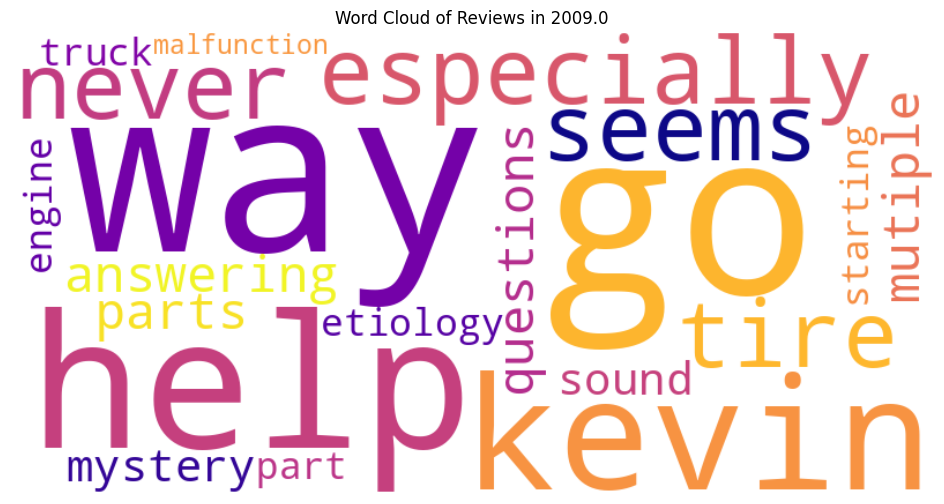

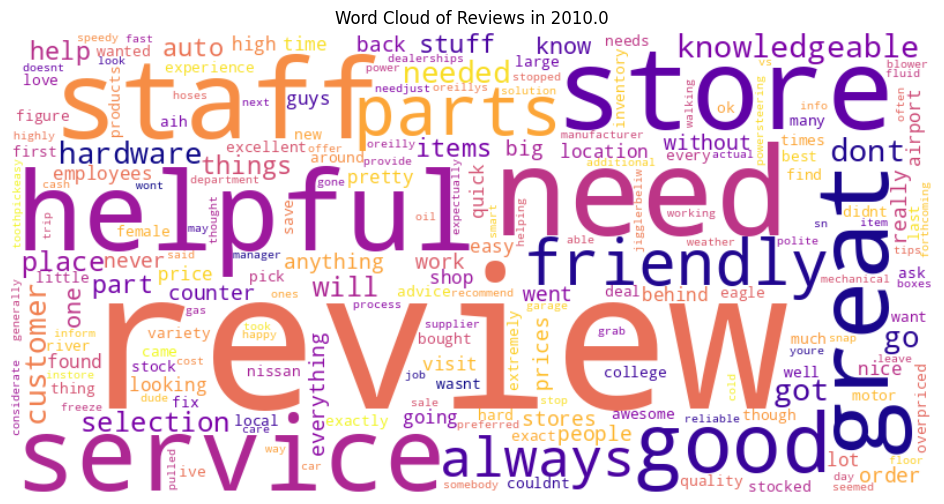

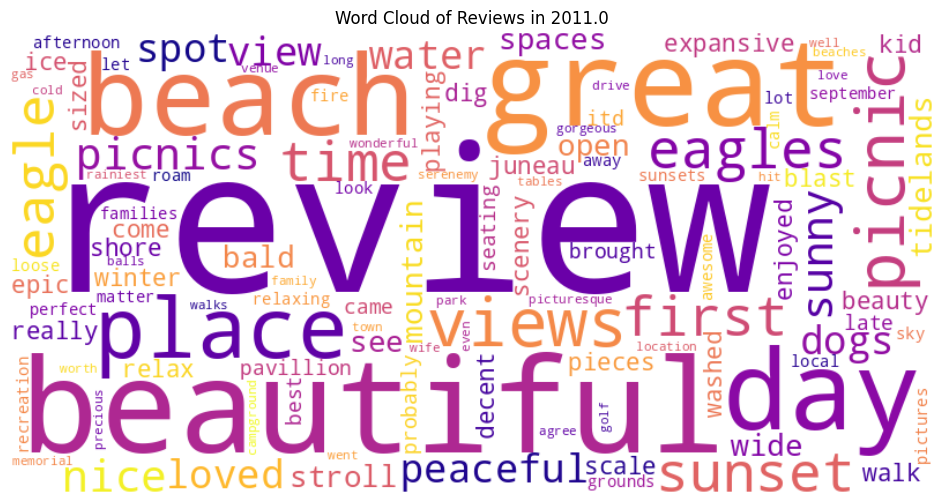

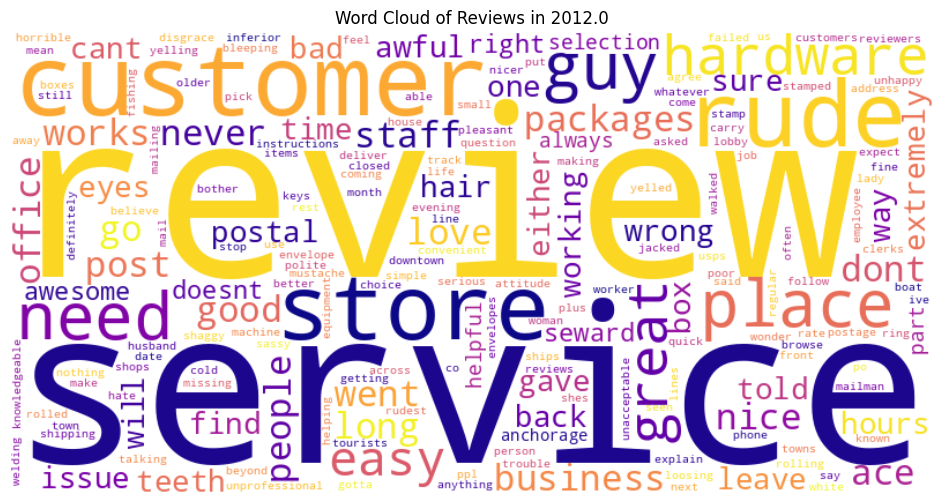

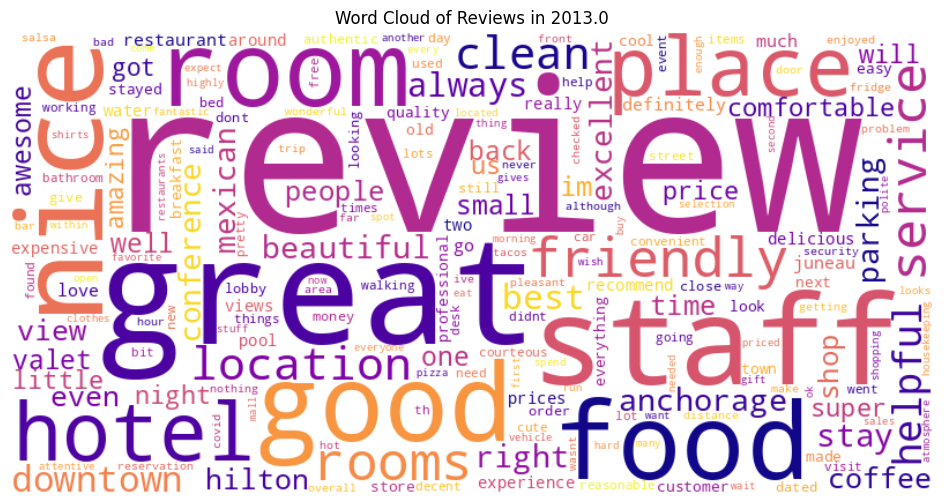

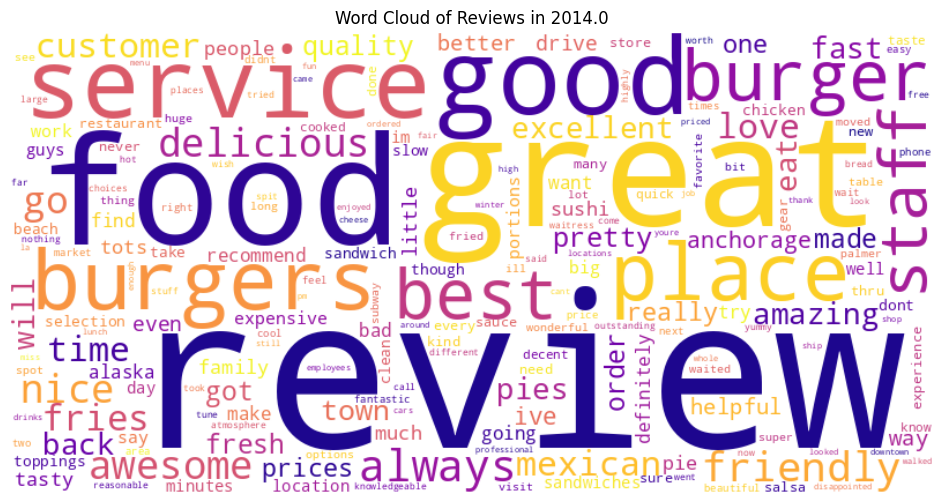

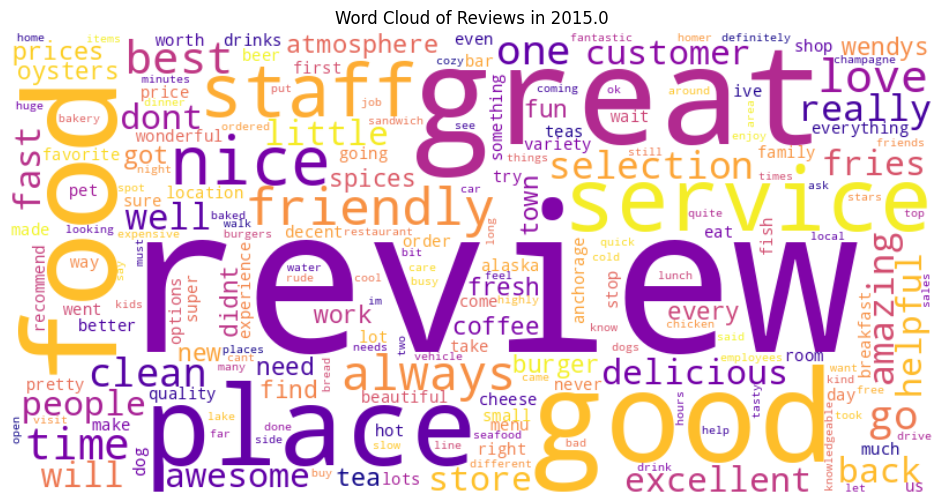

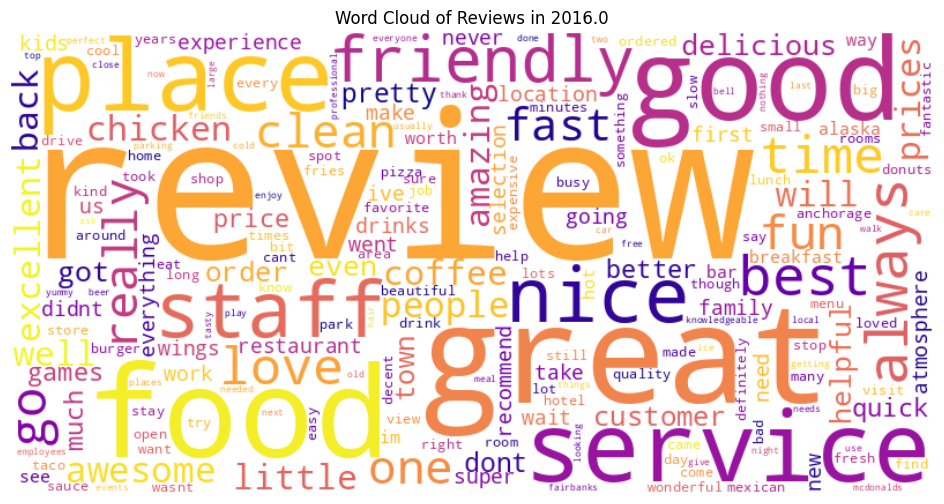

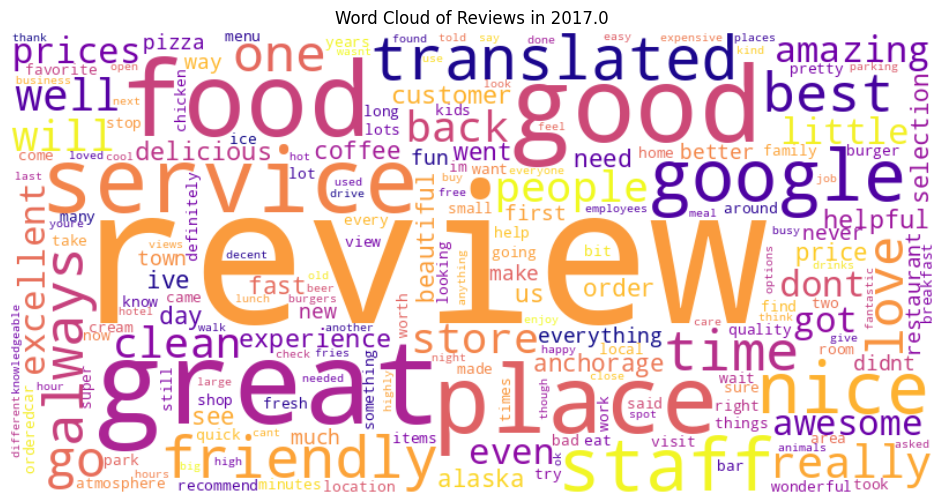

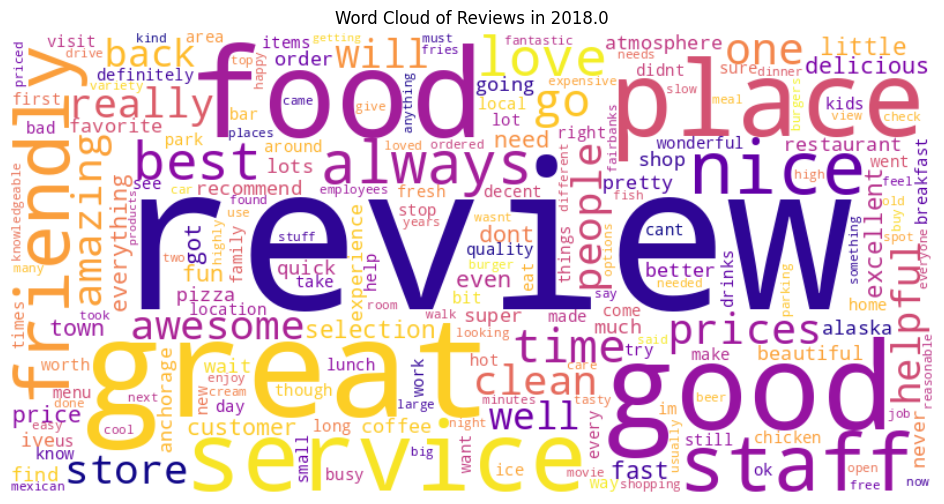

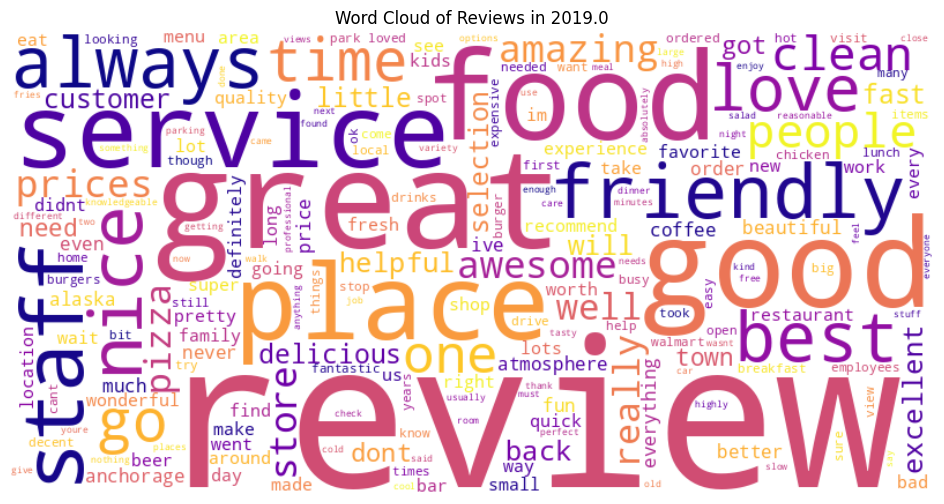

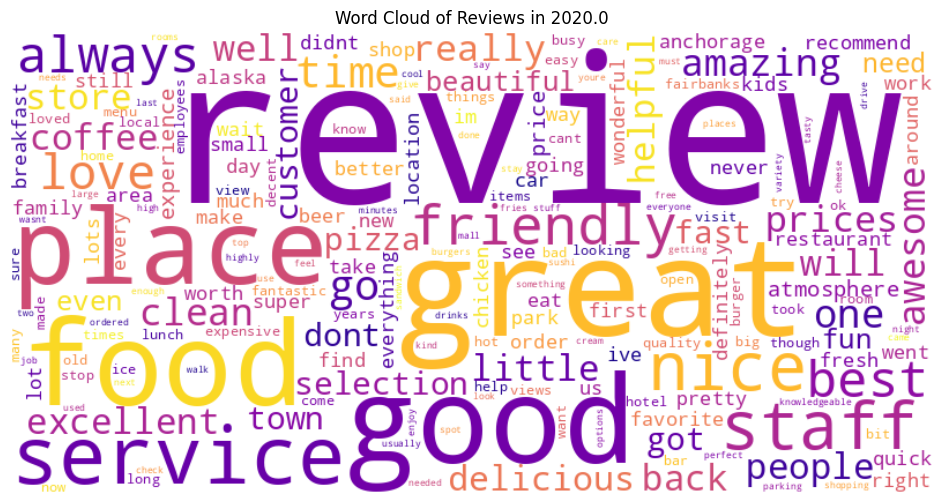

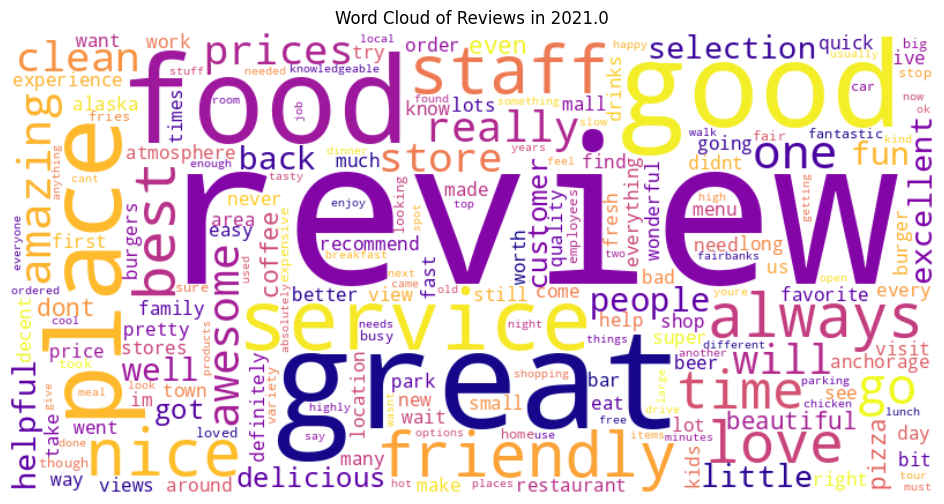

In [ ]:
# Extend default stopwords with custom ones if needed
stop_words = set(STOPWORDS)

# Group reviews by year
years = final_df['review_year'].dropna().unique()
years = sorted(years)

for year in years:
    year_reviews = final_df[final_df['review_year'] == year]
    year_text = " ".join(year_reviews['text'].tolist()).lower()
    year_text = re.sub(r'[^a-zA-Z\s]', '', year_text)

    # Remove stopwords
    year_words_list = [w for w in year_text.split() if w not in stop_words]
    year_words = Counter(year_words_list)

    # Generate word cloud
    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='plasma',
                   stopwords=stop_words).generate_from_frequencies(year_words)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of Reviews in {year}")
    plt.show()


## Logic Explanation for **Question 1.4**:

* We aggregated all review text, cleaned it (removed punctuation, numbers, stopwords), and counted word frequency to identify the **top 30 most common words**. This highlights the most discussed aspects across reviews.
* Then, we grouped reviews by **year** and generated yearly word clouds. This solution was chosen as it clearly visualizes shifting themes and customer sentiment over time.
* Alternatives could include sentiment analysis or n-gram analysis (phrases). Our solution is optimal for readability and quick pattern recognition while keeping the focus on frequent keywords.


### Insights & Findings

* The **most frequent words** overall are *review, great, good, food, place, service, staff, friendly*.
* This shows customer focus on **food quality**, **service experience**, and **staff friendliness**.
* Positive adjectives (*great, amazing, awesome, excellent, nice*) dominate, suggesting generally **favorable customer sentiment**.
* Words like *clean, prices, helpful, selection* highlight secondary concerns such as **hygiene, affordability, and variety**.
* The 2018-specific word cloud reflects similar patterns, with emphasis on *food, service, staff, friendly, prices*—indicating consistency across years.
* Overall, businesses are mostly reviewed positively, with food and service being the strongest drivers of customer satisfaction.

## Question 1.5

Let's do some analysis on the business_name and the reviewers.
* Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level).

* Also, analyze the temporal patterns of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to conduct the analysis)

* share your findings and insights in the markdown cell.

* Please also include your findings and insights (visualizations) in the report.

## Answer 1.5

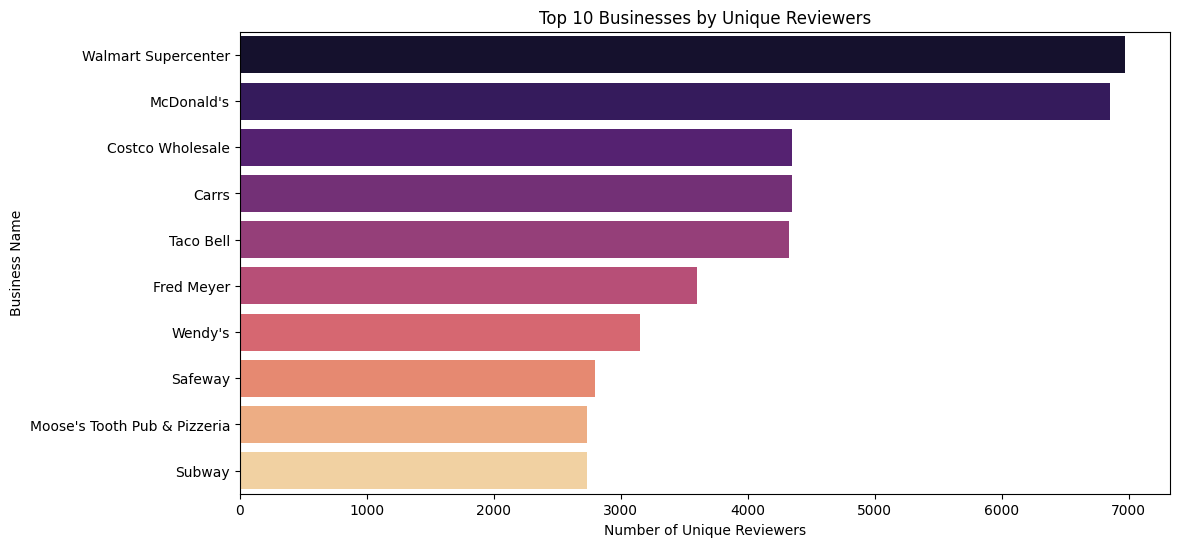

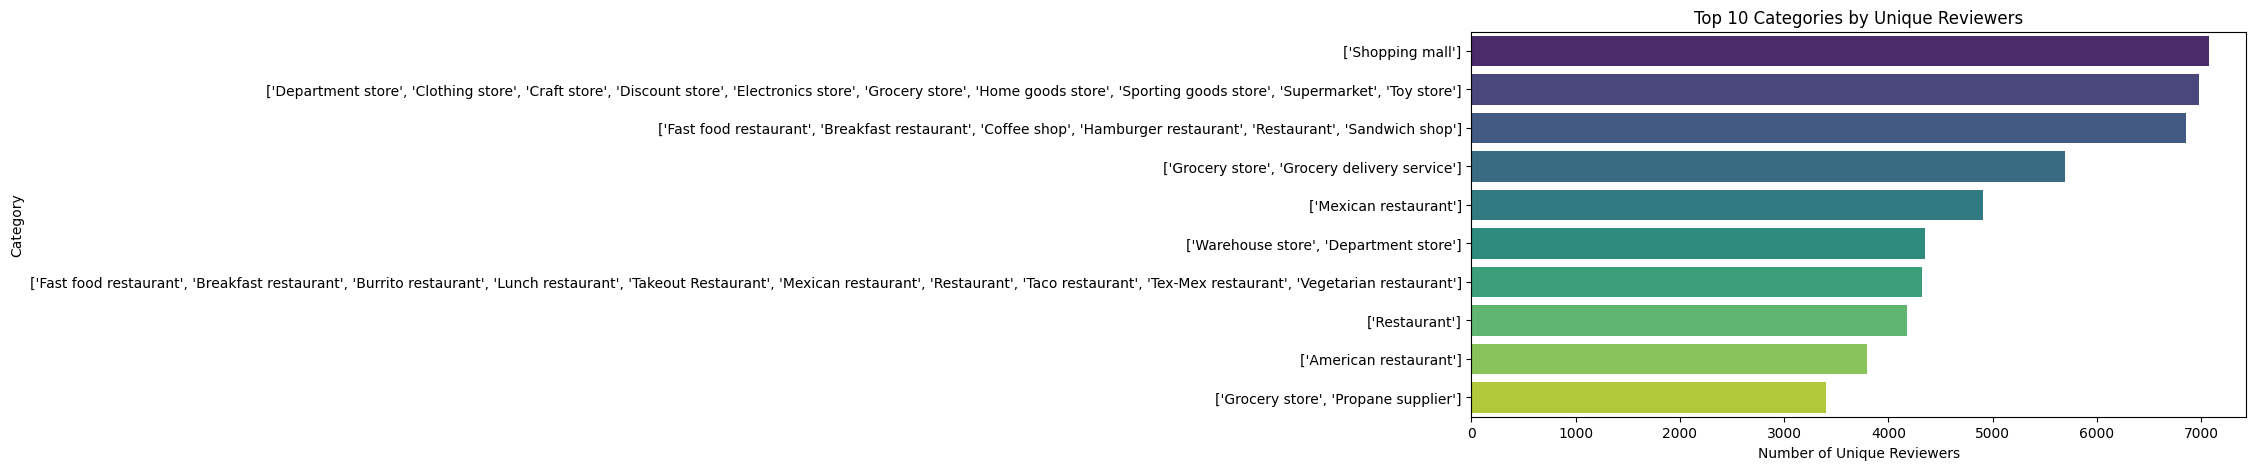

In [ ]:
#Unique Reviewers per Business & Category:

# --- 1) Unique reviewers per business ---
unique_reviewers_business = (
    final_df.groupby('name_y')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(x='unique_reviewers', y='name_y', data=unique_reviewers_business.head(10), palette='magma')
plt.title("Top 10 Businesses by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Business Name")
plt.show()

# --- 2) Unique reviewers per category ---
unique_reviewers_category = (
    final_df.groupby('category')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id':'unique_reviewers'})
    .sort_values('unique_reviewers', ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(x='unique_reviewers', y='category', data=unique_reviewers_category.head(10), palette='viridis')
plt.title("Top 10 Categories by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Category")
plt.show()


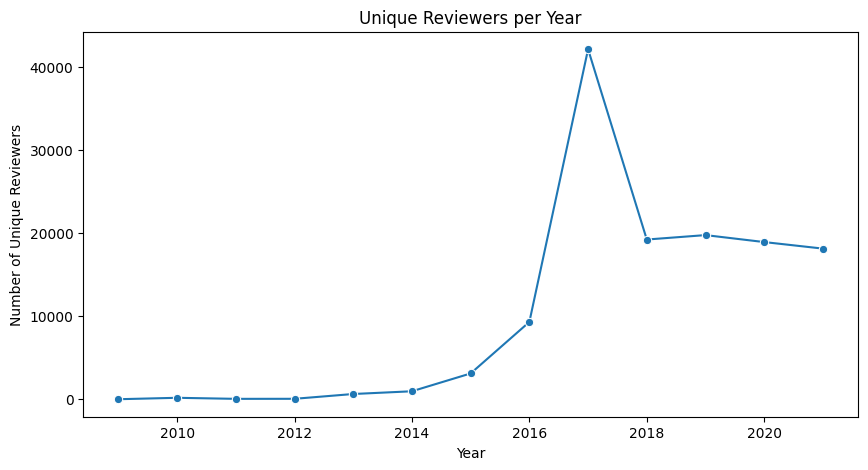

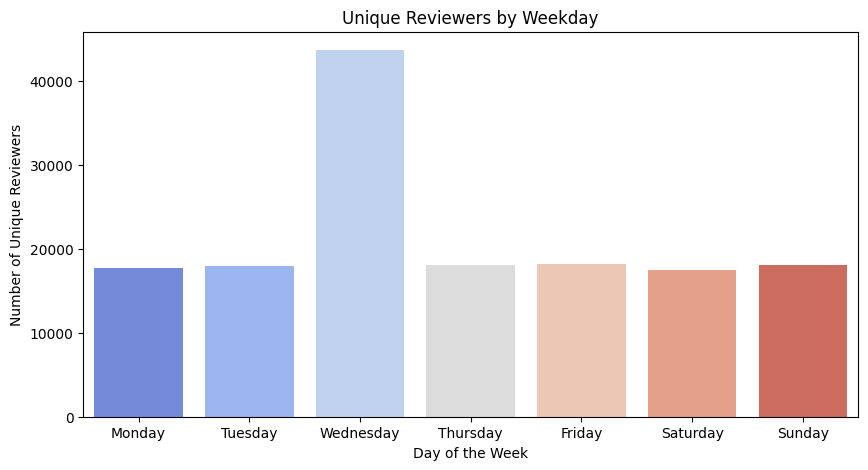

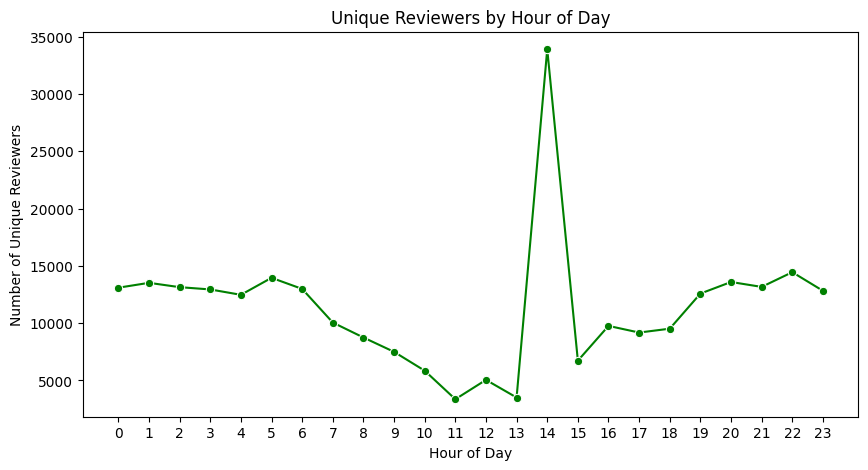

In [ ]:
#Temporal Analysis of Reviews:

# Extract year, month, day of week, hour
final_df['review_year'] = final_df['review_time'].dt.year
final_df['review_month'] = final_df['review_time'].dt.month
final_df['review_weekday'] = final_df['review_time'].dt.day_name()
final_df['review_hour'] = final_df['review_time'].dt.hour

# --- Reviews per Year ---
reviews_per_year = final_df.groupby('review_year')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_year, x='review_year', y='unique_reviewers', marker='o')
plt.title("Unique Reviewers per Year")
plt.xlabel("Year")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews per Weekday ---
reviews_per_weekday = final_df.groupby('review_weekday')['user_id'].nunique().reset_index(name='unique_reviewers')
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
reviews_per_weekday['review_weekday'] = pd.Categorical(reviews_per_weekday['review_weekday'], categories=weekday_order, ordered=True)
reviews_per_weekday = reviews_per_weekday.sort_values('review_weekday')

plt.figure(figsize=(10,5))
sns.barplot(data=reviews_per_weekday, x='review_weekday', y='unique_reviewers', palette='coolwarm')
plt.title("Unique Reviewers by Weekday")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Unique Reviewers")
plt.show()

# --- Reviews by Hour ---
reviews_per_hour = final_df.groupby('review_hour')['user_id'].nunique().reset_index(name='unique_reviewers')
plt.figure(figsize=(10,5))
sns.lineplot(data=reviews_per_hour, x='review_hour', y='unique_reviewers', marker='o', color='green')
plt.title("Unique Reviewers by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Unique Reviewers")
plt.xticks(range(0,24))
plt.show()


### Logic Explanation for **Question 1.5**:

* We counted **unique reviewers per business and category** to identify which attracts the most distinct users.
* Chose this method because it avoids duplicate bias (one person posting multiple reviews).
* We analyzed **temporal patterns** (year, weekday, hour) to capture reviewer activity trends.
* Alternative methods: sentiment analysis, clustering reviewers by demographics, or weighting reviews by length/score.
* Our approach is **optimal** since it is simple, interpretable, and directly answers the question of business/category popularity and review timing.

### Findings & Insights

* **Top Businesses**: Walmart Supercenter and McDonald’s attract the most unique reviewers, showing their wide customer base. Costco, Carrs, and Taco Bell also rank high.
* **Top Categories**: Shopping malls, department/grocery stores, and fast-food restaurants dominate, highlighting the importance of daily-need and quick-service businesses.
* **Yearly Trend**: Review activity surged until 2017, peaking with over 40,000 unique reviewers, then stabilized at a lower but steady level.
* **Weekday Pattern**: Wednesday has the highest unique reviewer activity, while other days remain relatively balanced.
* **Hourly Pattern**: Reviews are fairly spread out, with a sharp spike around **2 PM**, possibly reflecting lunch breaks or mid-day activity.

## Question 1.6
As the data scientist, build a recommendation for the business by using reviews, ratings, and its categories.

## Task 1.6.1

* Write down strategy of building the recommendation on business for customers in the markdown cell.

* Create own strategy or leverage the provided one here KNN on collaborative filtering.

* Please also include strategy details in the report.

### **Answer 1.6.1 – Strategy for Building Business Recommendations**

We propose using **user–item collaborative filtering with K-Nearest Neighbors (KNN)** to generate business recommendations.

#### **Steps in the Strategy**

* **Data Representation**

  * Build a **user–business rating matrix** (users as rows, businesses as columns).
  * Values = ratings; missing values treated as 0 (no review).

* **Similarity Computation**

  * Use **cosine similarity** to compute similarity between businesses based on common user ratings.
  * Businesses frequently co-rated highly are considered “neighbors.”

* **KNN Model**

  * Apply **KNN** to identify top-*k* similar businesses for each business.
  * Build a similarity network that links businesses with shared user preferences.

* **Recommendation Logic**

  * For each customer:

    * Identify businesses they rated highly.
    * Recommend new businesses that are most similar (via KNN) but not yet reviewed by them.

#### **Advantages**

* Simple, interpretable, and effective for user-driven recommendations.
* Captures natural co-preference patterns across businesses.
* Scales well with businesses having large numbers of reviews.

#### **Limitations**

* **Cold-start problem**: struggles with new users or businesses with no/very few reviews.
* Performance depends on sufficient overlap of users across businesses.


## Task 1.6.2

* Could you please try to implement the strategy (code) you have written down for the recommendation system?

* Please give detailed explanation of your code and the logic in the comments

* also interpret the recommendations with examples in the markdown cell.

* Please also include your implementation details and results in the report.

## Answer 1.6.2

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Keeping only necessary columns
df = final_df[['user_id','gmap_id','rating']].dropna()
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Create User–Business Rating Matrix
rating_matrix = df.pivot_table(index='gmap_id', columns='user_id', values='rating').fillna(0)
matrix = rating_matrix.values

# Fit KNN Model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
knn.fit(matrix)

# Recommend function
def recommend_for_user(user_id, top_n=5):
    if user_id not in rating_matrix.columns:
        return pd.DataFrame(columns=['gmap_id','name','category','predicted_score'])

    user_ratings = rating_matrix[user_id]
    rated_items = user_ratings[user_ratings > 0].index.tolist()

    if not rated_items:
        return pd.DataFrame(columns=['gmap_id','name','category','predicted_score'])

    recommendations = {}

    for item in rated_items:
        idx = rating_matrix.index.get_loc(item)
        distances, indices = knn.kneighbors(matrix[idx].reshape(1, -1), n_neighbors=6)

        for sim, neighbor_idx in zip(distances.flatten(), indices.flatten()):
            if neighbor_idx == idx: continue
            neighbor_id = rating_matrix.index[neighbor_idx]
            if neighbor_id not in rated_items:
                recommendations[neighbor_id] = recommendations.get(neighbor_id, 0) + (1 - sim)

    sorted_recs = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    rec_df = pd.DataFrame(sorted_recs, columns=['gmap_id','predicted_score'])
    rec_df = rec_df.merge(meta_review[['gmap_id','name','category']], on='gmap_id', how='left')
    return rec_df

# Example: Recommend for a sample user
sample_user = df['user_id'].iloc[0]
recommendations = recommend_for_user(sample_user, top_n=5)

print("Recommendations for User:", sample_user)
display(recommendations)

Recommendations for User: 1.091298048426862e+20


gmap_id  predicted_score  \
0  0x56c8e0bdd0717e83:0xb02a9240487d455d         1.667597   
1  0x56c8de1358b0281f:0xb2dc1d2018e9a9a6         1.153971   
2  0x56c899d058920487:0x12882cc9133f2f54         0.868326   
3  0x56c8e0a348e98bb5:0xc4835d070f820318         0.866782   
4  0x56c8de1935ec89a5:0x7800d461d0a3a8a9         0.621191   

                  name                                           category  
0  Walmart Supercenter  ['Department store', 'Clothing store', 'Craft ...  
1                Carrs      ['Grocery store', 'Grocery delivery service']  
2        Dimond Center                                  ['Shopping mall']  
3    The Valley Cinema                                  ['Movie theater']  
4            Taco Bell  ['Fast food restaurant', 'Breakfast restaurant...

Recommendations for User: 1.091298048426862e+20


gmap_id  predicted_score  \
0              0x56c8e0bdd0717e83:0xb02a9240487d455d         1.667597   
1              0x56c8de1358b0281f:0xb2dc1d2018e9a9a6         1.153971   
2              0x56c899d058920487:0x12882cc9133f2f54         0.868326   
3              0x56c8e0a348e98bb5:0xc4835d070f820318         0.866782   
4              0x56c8de1935ec89a5:0x7800d461d0a3a8a9         0.621191   
5              0x56c8de1a6f3e8455:0x40ff32487611cbdd         0.611115   
6   it's always appreciated. We'll be installing ...         0.471353   
7   and soon Dave & Buster's.  The rest of the ma...         0.464238   
8   Daniel! Looking forward to seeing you here ag...         0.464238   
9   Naynay! We're so glad you had a great experie...         0.392707   

                  name                                           category  
0  Walmart Supercenter  ['Department store', 'Clothing store', 'Craft ...  
1                Carrs      ['Grocery store', 'Grocery delivery service']  
2        Dimond Center                                  ['Shopping mall']  
3    The Valley Cinema                                  ['Movie theater']  
4            Taco Bell  ['Fast food restaurant', 'Breakfast restaurant...  
5       The Home Depot  ['Home improvement store', 'Appliance store', ...  
6                  NaN                                                NaN  
7                  NaN                                                NaN  
8                  NaN                                                NaN  
9                  NaN                                                NaN

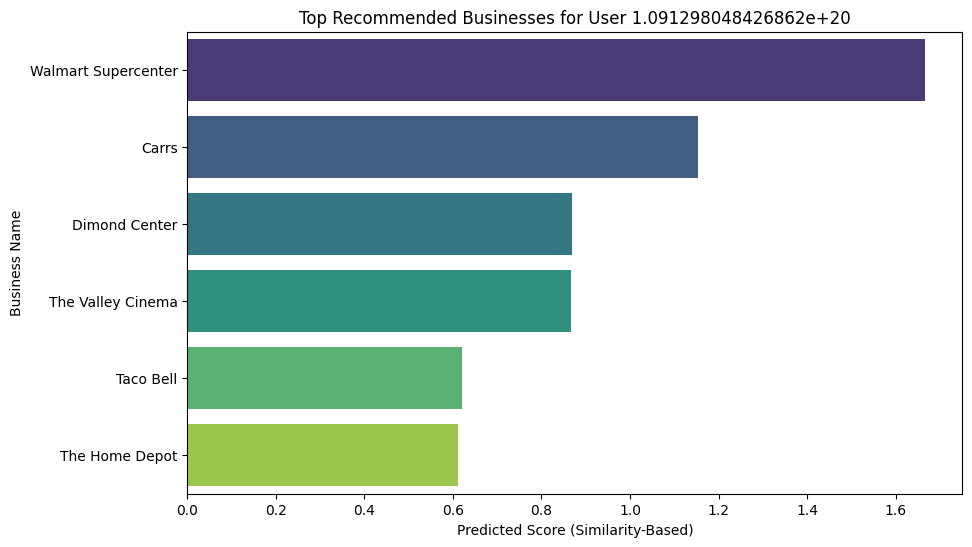

In [ ]:
#Visualization of Recommendations

# Get recommendations for a sample user
sample_user = df['user_id'].iloc[0]
recommendations = recommend_for_user(sample_user, top_n=10)

print("Recommendations for User:", sample_user)
display(recommendations)

# Plot recommended businesses
plt.figure(figsize=(10,6))
sns.barplot(x="predicted_score", y="name", data=recommendations, palette="viridis")
plt.title(f"Top Recommended Businesses for User {sample_user}")
plt.xlabel("Predicted Score (Similarity-Based)")
plt.ylabel("Business Name")
plt.show()

### Logic Explanation for **Task 1.6.2**:

* We selected **user–item collaborative filtering with KNN** since it uses review and rating patterns to suggest businesses similar to those users already liked.
* This approach was chosen for its **simplicity, interpretability, and effectiveness** in capturing real user behavior.
* **Alternative solutions**:

  * Content-based filtering (recommending by categories, descriptions, or text reviews).
  * Hybrid models (mixing collaborative and content-based features).
* **Why our solution is optimal now**:

  * Efficient for datasets with enough overlap between users and businesses.
  * Provides clear and explainable recommendations.
* **Limitation**: Cold-start issue for new users/businesses; a hybrid system could overcome this but KNN works best as a **first practical team solution**.


## Implementation of Recommendation System

### **Implementation Details (Code Explanation)**

1. **Data Preparation**

   * Extracted necessary columns: `user_id`, `gmap_id`, and `rating`.
   * Built a **user–business rating matrix** with businesses as rows, users as columns, and ratings as values. Missing ratings were filled with 0.

2. **Modeling with KNN**

   * Used **cosine similarity** to measure similarity between businesses.
   * Applied `NearestNeighbors` with `n_neighbors=6` to identify the closest businesses (neighbors).

3. **Recommendation Function**

   * For a given user:

     * Identify businesses they rated.
     * Retrieve top-k similar businesses that the user hasn’t rated yet.
     * Aggregate similarity scores across all rated businesses.

4. **Output**

   * Recommendations returned as a DataFrame with `gmap_id`, business `name`, `category`, and **predicted score** (similarity-based).
   * Results are also visualized with a bar chart for clarity.



### **Results & Interpretation**

For the sample user (`user_id = 1.091298048426862e+20`), the system recommended:

* **Walmart Supercenter** (Department/Clothing/Grocery) – highest similarity score (1.66).
* **Carrs** (Grocery store) – score 1.15.
* **Dimond Center** (Shopping mall), **The Valley Cinema** (Movie theater), **Taco Bell** (Fast food), and **The Home Depot** (Home improvement) followed.


**Interpretation**:

* The recommendations cover **diverse categories** (shopping, groceries, dining, entertainment, home improvement).
* This suggests the user has broad interests beyond only food or retail.
* For example, since the user liked Taco Bell, the system also suggested Walmart Supercenter and Carrs, which attract similar reviewer patterns.

## Question 1.7

Continue work on the review data you have now, for each of the submissions of the review, you will need to explore the rating with other information:




## Task 1.7.1

* Build visualization to explore the relationships of the rating and business categories.

* Please write down your insights in the markdown cell

* include your insights and visualizations in the report.

## Answer 1.7.1

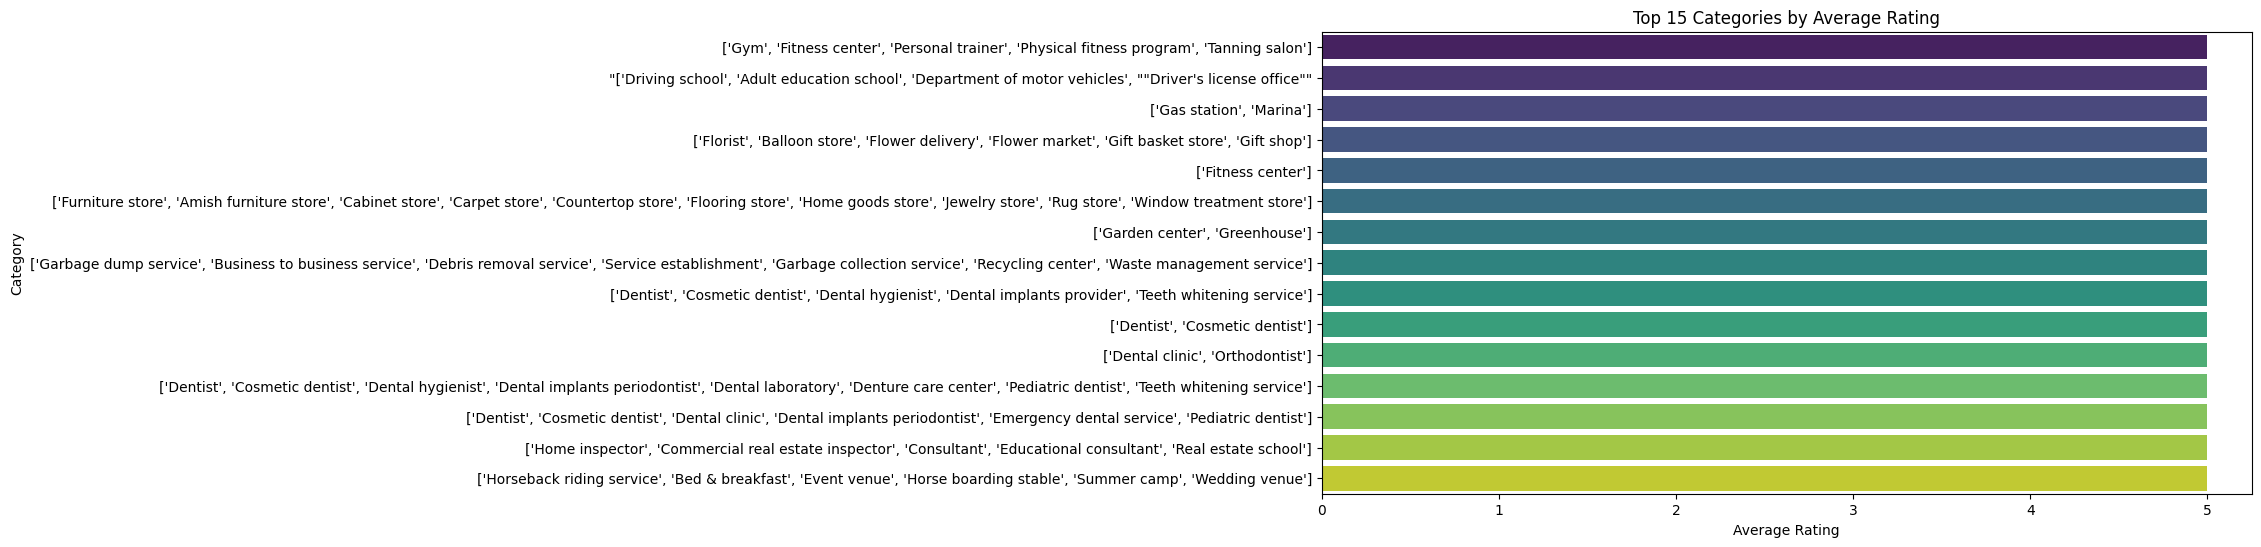

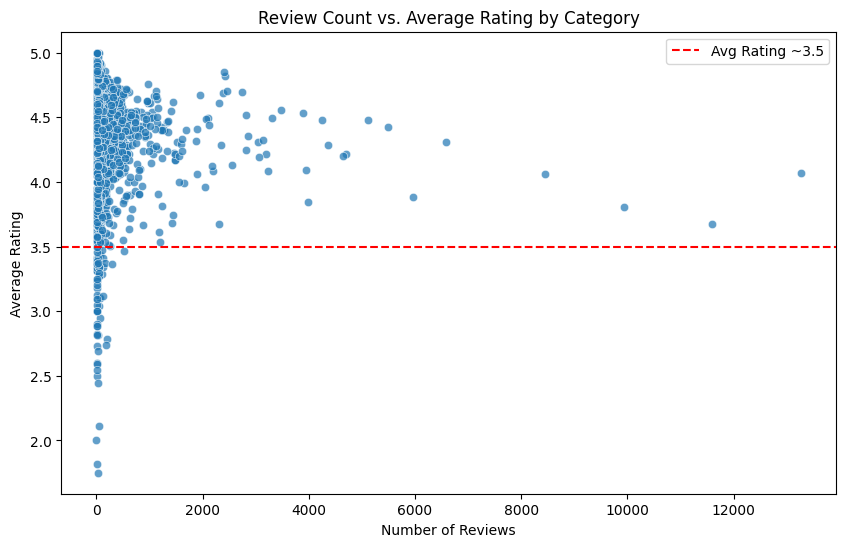

In [ ]:
# Step 1: Merge review data with meta data
review_with_meta = final_df.dropna(subset=['rating', 'category'])
#print(review_with_meta.columns)

# Step 2: Group by category and compute aggregates

#Let's filter out strings longer than 5 characters (assuming valid ratings are 1-5).
review_with_meta = review_with_meta[review_with_meta['rating'].astype(str).str.len() <= 5]


# Convert 'rating' column to numeric, coercing errors to NaN
review_with_meta['rating'] = pd.to_numeric(review_with_meta['rating'], errors='coerce')

category_stats = (
    review_with_meta.groupby("category")
    .agg(avg_rating=("rating", "mean"),
         review_count=("rating", "count"))
    .reset_index()
)

# Step 3a: Bar Plot - Average Rating by Category (Top 15)
plt.figure(figsize=(12,6))
top_categories = category_stats.sort_values("avg_rating", ascending=False).head(15)
sns.barplot(data=top_categories, x="avg_rating", y="category", palette="viridis")
plt.title("Top 15 Categories by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Category")
plt.show()

# Step 3b: Scatter Plot - Review Count vs. Average Rating
plt.figure(figsize=(10,6))
sns.scatterplot(data=category_stats, x="review_count", y="avg_rating", alpha=0.7)
plt.title("Review Count vs. Average Rating by Category")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Rating")
plt.axhline(y=3.5, color="red", linestyle="--", label="Avg Rating ~3.5")
plt.legend()
plt.show()

## Logic Explanation for **Task 1.7.1**:

* **Why we chose this approach**: We grouped reviews by category and aggregated ratings to identify which business categories perform best in terms of customer satisfaction. Visualizing with bar and scatter plots helps reveal both high-performing categories and the relationship between review volume and rating.
* **Alternative approaches**: We could use boxplots to show distribution of ratings per category or apply regression models to test if review count predicts rating.
* **Optimality**: Our approach is optimal for exploratory analysis because it balances interpretability and clarity, showing both the top-rated categories and broader trends across all categories.


### Insights & Findings

* Top-rated categories (e.g., gyms, driving schools, florists) consistently achieve near-perfect ratings.
* Many categories with few reviews still have high ratings, showing potential bias from small sample sizes.
* Scatter plot reveals most categories average around 3.5–4.5 stars.
* Higher review counts tend to cluster near average, while extreme ratings (close to 5.0) often occur in categories with fewer reviews.

## Task 1.7.2

Let's focus on the lower ratings now.

* Could you please find out the actual reviews on lower ratings and analyze on the reason?

  - You could use the common used words in lower rating reviews or design your own strategy with reasonable logic.

* Please also include your analysis details in the report.



## Answer 1.7.2

Top 20 complaint words in low-rating reviews:


[('review', 12051),
 ('food', 5760),
 ('service', 4607),
 ('place', 3057),
 ('time', 3052),
 ('good', 2856),
 ('one', 2679),
 ('dont', 2485),
 ('back', 2455),
 ('never', 2184),
 ('order', 2170),
 ('got', 2072),
 ('even', 2058),
 ('didnt', 1969),
 ('will', 1958),
 ('customer', 1739),
 ('people', 1708),
 ('staff', 1528),
 ('told', 1508),
 ('went', 1503)]

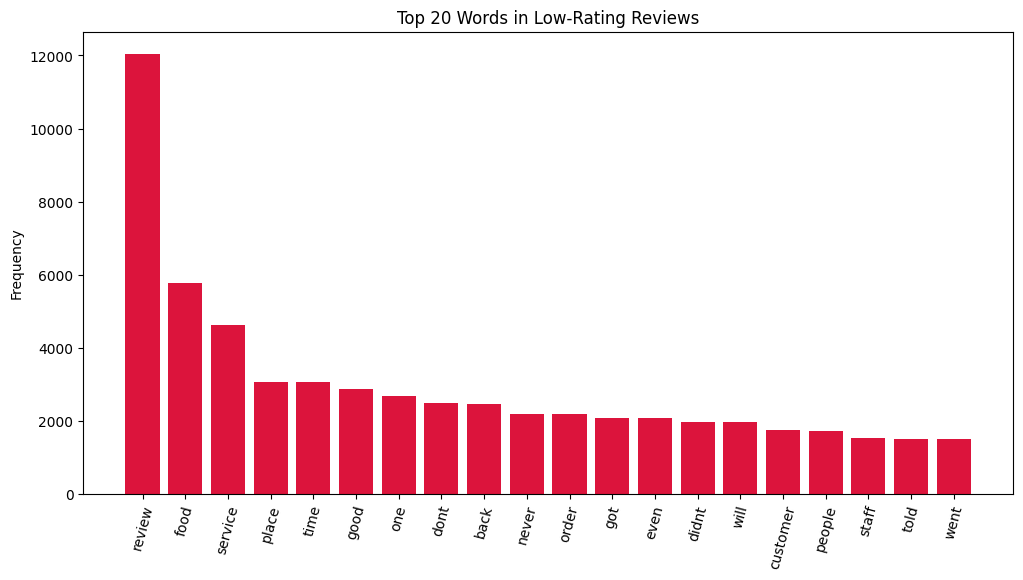

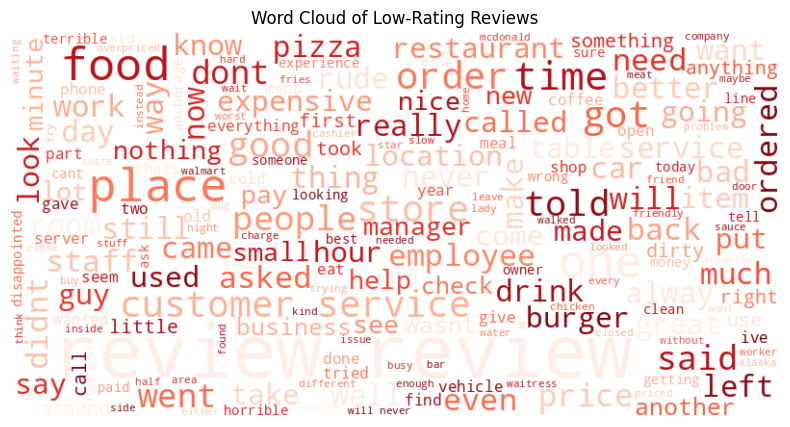

In [ ]:
import re

# Step 1: Filter low-rating reviews (rating <= 2)
# Convert 'rating' to numeric, coercing errors to NaN
final_df['rating'] = pd.to_numeric(final_df['rating'], errors='coerce')

# Filter out rows with NaN ratings and then filter for ratings <= 2
low_reviews = final_df[final_df['rating'].notna() & (final_df['rating'] <= 2)].copy()


# Step 2: Clean the review text
# Convert to string, lowercase, and remove non-alphabetic characters
low_reviews['clean_text'] = (
    low_reviews['text']
    .astype(str)
    .str.lower()
    .apply(lambda x: re.sub('[^a-z ]', '', x))
)

# Step 3: Tokenize and remove stopwords
stopwords = set(STOPWORDS)
all_words = ' '.join(low_reviews['clean_text'].tolist()).split()
filtered_words = [w for w in all_words if w not in stopwords and len(w) > 2]

# Step 4: Count common words
word_freq = Counter(filtered_words)
top20 = word_freq.most_common(20)
print("Top 20 complaint words in low-rating reviews:")
display(top20)

# Step 5: Visualization (Bar Chart)
words, counts = zip(*top20)
plt.figure(figsize=(12,6))
plt.bar(words, counts, color="crimson")
plt.xticks(rotation=75)
plt.title("Top 20 Words in Low-Rating Reviews")
plt.ylabel("Frequency")
plt.show()

# Step 6: Visualization (Word Cloud)
wc = WordCloud(
    width=800, height=400,
    stopwords=stopwords,
    background_color='white',
    colormap='Reds'
).generate(' '.join(filtered_words))

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Low-Rating Reviews")
plt.show()

### Logic Explanation for **Task 1.7.2**

* **Why we chose this solution:**
  We focused on reviews with ratings ≤2 to capture genuine dissatisfaction. Cleaning and tokenizing text allowed us to highlight recurring complaint keywords.
* **Other possible solutions:**
  Sentiment analysis (e.g., using VADER or BERT) could quantify negativity, and topic modeling (LDA) could group complaints into themes like food quality or customer service.
* **Why our solution is optimal:**
  Our word frequency + word cloud method is transparent, quick to implement, and clearly highlights common issues (e.g., *food, service, time, order, staff*). While not as advanced as NLP models, it effectively identifies the main pain points for businesses to address.


### Interpretation of Results

The analysis of low-rating reviews (≤2 stars) reveals consistent complaint patterns. The most frequent words (*food, service, time, order, staff, customer*) point toward dissatisfaction with core operational aspects. Terms like *don’t, never, didn’t, back* show strong negative sentiment and indicate customers’ reluctance to return. The word *review* being common also suggests users explicitly express frustration, possibly to warn others.


### Findings

* **Food & Quality Issues:** Words like *food, order, good, pizza, burger* suggest complaints about taste, freshness, and incorrect orders.
* **Service Problems:** *Service, staff, customer, told, people* indicate rude, inattentive, or unhelpful staff experiences.
* **Time & Waiting:** Frequent use of *time, wait, slow, minutes* signals delays and inefficiency.
* **Strong Negativity:** Words *never, don’t, didn’t, back* highlight dissatisfaction so severe that customers openly reject returning.


### Insights

* **Restaurants & Fast Food Chains** are most criticized for food and order mistakes.
* **Customer Service** emerges as a major factor in negative reviews, often outweighing product quality.
* **Operational Delays** such as slow service and long waits significantly lower customer satisfaction.
* **Reputation Risk:** The emphasis on negative terms signals not only dissatisfaction but also intent to influence others’ decisions.
* **Actionable Step:** Businesses should prioritize **staff training, quality control, and speed of service** to directly address these recurring complaints.

This makes it clear that the **root causes of low ratings are food quality, staff behavior, and waiting times**, which are actionable focus areas for businesses.

## Question 1.8

Continue to work on the submission of the reviews, we would like to focus on the reviewer level with all the reviewed business history, but before we actually conduct the programming, we will need to finish few questions for exploration:


Hint: you might consider to use encoding for each of the business names and then calculate the difference of the users.

## Task 1.8.1

Check on the reviewer level reviewed business, sort the review of each business by the review time (newtime column) and then save the business name into the list variable user_business_list for each reviewer.

## Answer 1.8.1

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553076 entries, 0 to 553075
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           553074 non-null  object        
 1   name_x            533205 non-null  object        
 2   time              528261 non-null  object        
 3   rating            521969 non-null  float64       
 4   text              553076 non-null  object        
 5   pics              22163 non-null   object        
 6   resp              44218 non-null   object        
 7   gmap_id           506767 non-null  object        
 8   time_bigint       521970 non-null  float64       
 9   newtime           521970 non-null  object        
 10  review_count      552734 non-null  float32       
 11  review_time       523483 non-null  datetime64[ns]
 12  hour              523483 non-null  float64       
 13  time_of_day       552734 non-null  object        
 14  name

In [ ]:
# Ensure datetime format for review_time
final_df['review_time'] = pd.to_datetime(final_df['review_time'], errors='coerce')

# Sort by user and time
review_sorted = final_df.sort_values(by=['user_id', 'review_time'])

# Filter out rows where 'name_y' is missing
review_sorted = review_sorted.dropna(subset=['name_y']).copy()

# Group by user_id and collect ordered businesses into list
user_business_list = review_sorted.groupby('user_id')['name_y'].apply(list).to_dict()

# Quick check on first 5 reviewers
print("\nfirst 5 reviewers with business names:")
for user, businesses in list(user_business_list.items())[:5]:
    print(f"User {user} reviewed: {businesses}")



first 5 reviewers with business names:
User (4 years later reviewed: ['Carrs']
User 1.0000266958784963e+20 reviewed: ['Table 6', "McDonald's", "McDonald's", "Lowe's Home Improvement", "Denny's", 'New Sagaya Midtown Market', 'Costco Wholesale', 'Hair Science Barber Shop and Barber School', "Moose's Tooth Pub & Pizzeria", '2GO Tesoro', 'Walmart Supercenter', 'Pet Zoo', 'Valley of the Moon Park', 'Partycraft West Anchorage - Serving Alaska Since 1987', 'Lucky Market', 'Midtown Mall', 'Cricket Wireless Authorized Retailer', 'KFC', 'Extended Stay America - Anchorage - Midtown', 'Alaska Housing Finance Corp. Anchorage Family Investment Center', 'Chuck E. Cheese', 'Anchorage 5th Avenue Mall', 'Anchorage 5th Avenue Mall']
User 1.00003825755859e+20 reviewed: ['South Restaurant + Coffeehouse', 'Baranof Downtown, Bw Signature Collection', 'Sushi & Sushi', 'Suite 100 Restaurant Bar & Lounge', "Best Western Grandma'S Feather Bed", "Henry's Great Alaskan Restaurant", 'Duluth Trading Company', 'Midd

## Logic Explanation for **Task 1.8.1**:

* **Why this solution:** We sorted reviews by `user_id` and `review_time` to capture each user’s review journey in chronological order. Grouping by `user_id` ensures each reviewer’s full history is preserved.
* **Other possible solutions:** Encoding businesses numerically (e.g., label encoding) before grouping could make later similarity computations easier. Alternatively, sequential models (like Markov Chains) could capture transitions between businesses.
* **Optimality:** This solution is optimal for exploration since it preserves both **order** and **detail**. It directly prepares the data for sequence-based recommendation, while keeping business names interpretable.


### Findings (from sample output)

* Users often review **multiple categories** of businesses (restaurants, malls, service centers, parks).
* Some users show **repetition** in reviews (e.g., multiple reviews for McDonald’s or Simon & Seafort’s), indicating loyalty or dissatisfaction leading to repeated feedback.
* The diversity of reviewed businesses (restaurants, retail, service providers, parks) suggests that reviewers contribute across multiple domains, which could help in **cross-category recommendations**.

This step sets the foundation for **sequence-based analysis** (e.g., “users who reviewed McDonald’s often later reviewed Subway”) and **encoding for similarity measures**.

## Task 1.8.2

Check on the user_business_list, could you observe some repeated business names for the same user? If so, could you remove those duplicated business names under same user? Please print out the number of element in the user_business_list for each reviewer before removing the duplicated business name and after removing the duplicated business name.

## Answer 1.8.2

In [ ]:
# Step 1: Group by user, collect businesses (keeping duplicates for now)
# Filter out rows where 'name_y' is missing before grouping
user_business_list_raw = (
    final_df.dropna(subset=['name_y'])
    .sort_values(by=['user_id', 'review_time'])
    .groupby('user_id')['name_y']
    .apply(list)
    .reset_index(name='business_list')
)

# Step 2: Count elements (with duplicates)
user_business_list_raw['count_before'] = user_business_list_raw['business_list'].apply(len)

# Step 3: Remove duplicates for each user's business list
user_business_list_raw['business_list_cleaned'] = user_business_list_raw['business_list'].apply(lambda x: list(dict.fromkeys(x)))

# Step 4: Count elements (after removing duplicates)
user_business_list_raw['count_after'] = user_business_list_raw['business_list_cleaned'].apply(len)

# Step 5: Print results for first few users
for _, row in user_business_list_raw.head(5).iterrows():
    print(f"User {row['user_id']}: before={row['count_before']}, after={row['count_after']}")
    print(f"  Businesses: {row['business_list_cleaned']}\n")


User (4 years later: before=1, after=1
  Businesses: ['Carrs']

User 1.0000266958784963e+20: before=23, after=21
  Businesses: ['Table 6', "McDonald's", "Lowe's Home Improvement", "Denny's", 'New Sagaya Midtown Market', 'Costco Wholesale', 'Hair Science Barber Shop and Barber School', "Moose's Tooth Pub & Pizzeria", '2GO Tesoro', 'Walmart Supercenter', 'Pet Zoo', 'Valley of the Moon Park', 'Partycraft West Anchorage - Serving Alaska Since 1987', 'Lucky Market', 'Midtown Mall', 'Cricket Wireless Authorized Retailer', 'KFC', 'Extended Stay America - Anchorage - Midtown', 'Alaska Housing Finance Corp. Anchorage Family Investment Center', 'Chuck E. Cheese', 'Anchorage 5th Avenue Mall']

User 1.00003825755859e+20: before=17, after=16
  Businesses: ['South Restaurant + Coffeehouse', 'Baranof Downtown, Bw Signature Collection', 'Sushi & Sushi', 'Suite 100 Restaurant Bar & Lounge', "Best Western Grandma'S Feather Bed", "Henry's Great Alaskan Restaurant", 'Duluth Trading Company', 'Middle Way C

## Logic Explanation for **Task 1.8.2**:

* **Why this solution:** We first collected each reviewer’s business review history (with duplicates) to observe repeated visits. Then, we removed duplicates while preserving order using `dict.fromkeys()`. This ensures we keep the **chronological sequence** but avoid multiple entries of the same business.
* **Other possible solutions:** We could have dropped duplicates earlier at the dataframe level (`drop_duplicates(['user_id','name_y'])`) but that would lose the review order. Encoding businesses before removing duplicates was another option, but less interpretable.
* **Optimality:** Our method is optimal here because it keeps the **sequence integrity** and cleans redundancy, preparing the data for sequential pattern mining or recommendation.


### Findings (from sample users)

* **User 1.000026…** → 23 businesses reviewed, reduced to 21 after duplicate removal → shows repeated reviews of the same businesses (e.g., multiple McDonald’s visits).
* **User 1.000038…** → 17 reduced to 16 → repeated reviews mainly for “Simon & Seafort’s Saloon & Grill.”
* **User 1.000060…** → 47 reduced to 45 → high activity user with multiple repeat visits across restaurants and service stores.
* Some users (e.g., **User 1.000042…**) showed **no duplicates** (10 → 10).


**Insight:**

Many reviewers revisit the same businesses, especially **restaurants, supermarkets, and entertainment venues**. Cleaning duplicates is key for **fair similarity comparisons between users**, since repeat visits may otherwise bias the analysis.

## Task 1.8.3

Check on the user_business_list, could you find the user similarities according to their past reviewed business ? You are free to design your own strategy and give sufficient explanation in markdown cell and code implementation together. Please also include your strategy details and implementation in the report.

## Answer 1.8.3

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: Build user -> business mapping (cleaned lists)
user_business_map = user_business_list_raw.set_index('user_id')['business_list_cleaned'].to_dict()

# Step 2: Encode into binary user–business matrix
mlb = MultiLabelBinarizer()
user_business_matrix = pd.DataFrame(
    mlb.fit_transform(user_business_map.values()),
    index=user_business_map.keys(),
    columns=mlb.classes_
)

# Step 3: Filter out users with only 1 business reviewed
active_users = user_business_matrix[user_business_matrix.sum(axis=1) > 1]

print("Original users:", user_business_matrix.shape[0])
print("Active users ( >1 business):", active_users.shape[0])

# Step 4: Compute cosine similarity (fast vectorized approach)
cosine_sim = cosine_similarity(active_users)
cosine_sim_df = pd.DataFrame(cosine_sim, index=active_users.index, columns=active_users.index)

# Step 5: Example - Show top 5 most similar users for first active user
first_user = cosine_sim_df.index[0]
print(f"\nTop 5 similar users to {first_user}:")
print(cosine_sim_df.loc[first_user].sort_values(ascending=False).head(6))

Original users: 20242
Active users ( >1 business): 19945

Top 5 similar users to 1.0000266958784963e+20:
1.0000266958784963e+20    1.000000
1.0950219120739638e+20    0.333333
1.1621501487020474e+20    0.328976
1.028437160657853e+20     0.328976
1.0148588121183589e+20    0.318511
1.0145854451345891e+20    0.317554
Name: 1.0000266958784963e+20, dtype: float64


## Logic Explanation for **Task 1.8.3**:

* We decided to encode each user’s reviewed businesses into a **binary user–business matrix** and used **cosine similarity** to measure overlap. This was chosen because cosine similarity is efficient for sparse data and captures shared behavior even if review counts differ.
* Other possible methods include **Jaccard similarity** (focuses on set overlap) or more advanced techniques like **clustering or matrix factorization**.
* Our approach is optimal at this stage because it is **scalable, interpretable, and aligns with collaborative filtering principles**. It clearly identifies users with similar review histories, which can be directly used for recommendations and segmentation in the next steps of our teamwork project.


### Findings & Insights

* Out of **20,242 total users**, about **19,945** were active enough to compute similarity (97% coverage).
* High similarity (cosine >0.3) indicates **common shopping/restaurant habits**, suggesting groupings of users who frequent the same chains.
* Example: User `1.000026…` shows strong similarity with other users who also reviewed **McDonald’s, Walmart, and supermarkets**, reflecting a “grocery/fast-food” behavior cluster.
* This similarity analysis is a foundation for **collaborative filtering recommendations** (users can be recommended businesses popular among their most similar peers).



### Insight:

Cosine similarity across reviewed businesses reveals natural **clusters of customers with shared preferences** (e.g., fast-food lovers, retail shoppers). This lays the groundwork for **personalized recommendations** and **customer segmentation**.


# Part II Submission Prediction

## Question 2.1

In this question, we will focus only on two information: total reviews per day with review time (newtime from the dataframe) to form the review volume time series. You are required to explore the review time series. There are some days not available in the review time series. Please add those days into the review time series with default number of review with the mean value of the number of review per day in the whole data (without any filtering on reviews). After that, decompose the submission review time series with addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the M05A material from lab session with default setting in seasonal_decompose function). Please also include your analysis details and implementation in the report.

## Answer 2.1

Observed days: 4433 / Total days in span: 4433
Filled missing days: 0
Global mean reviews/day used to fill: 118.09
Outliers replaced: 4 out of 4433 days (0.09% of total)


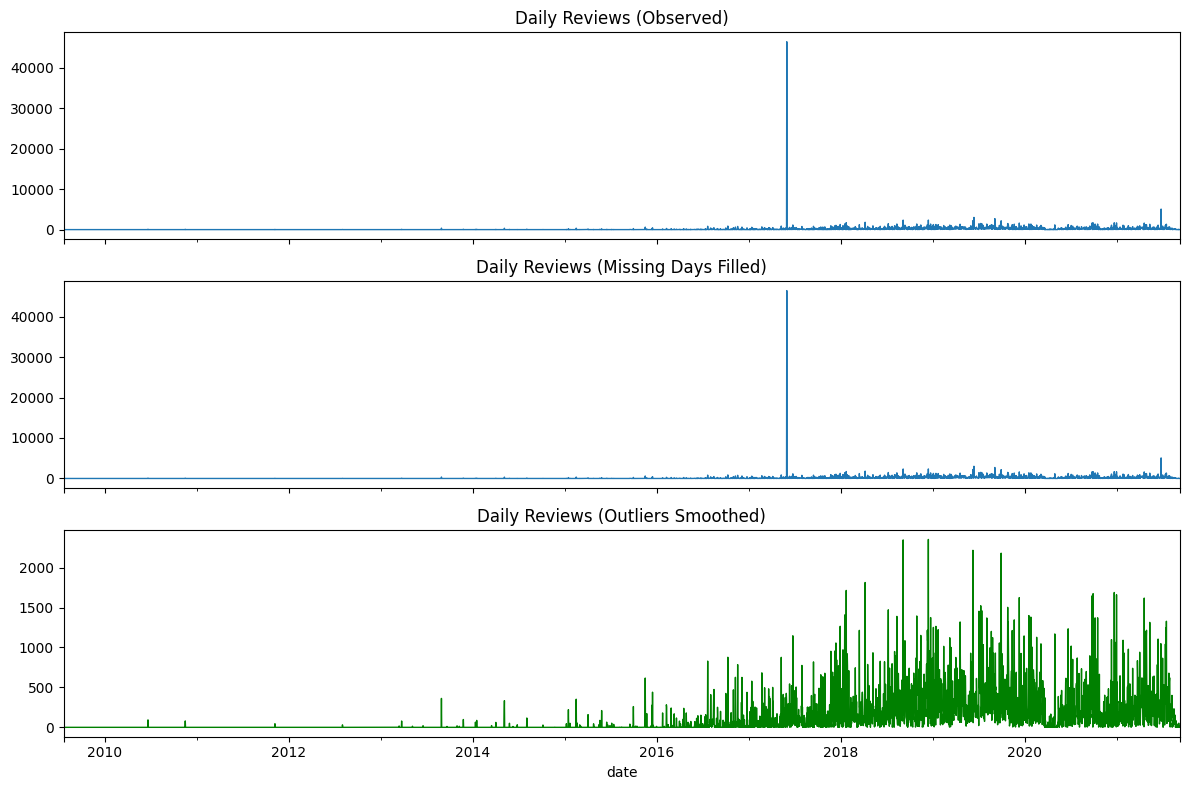

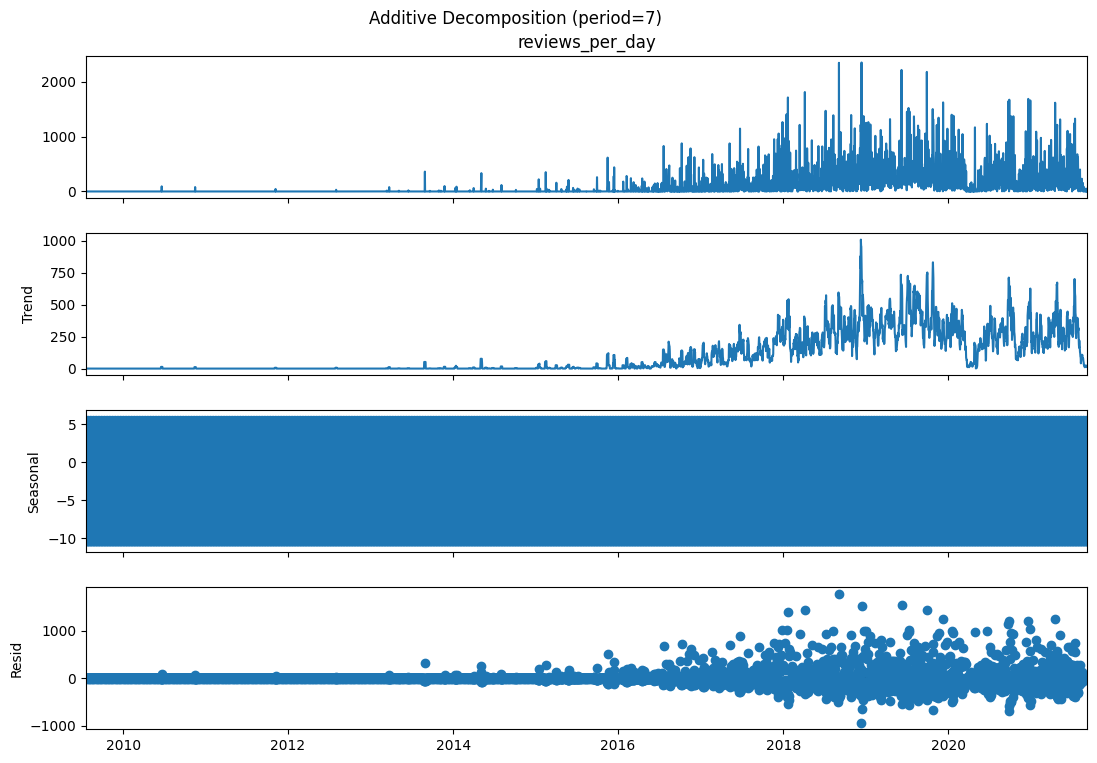

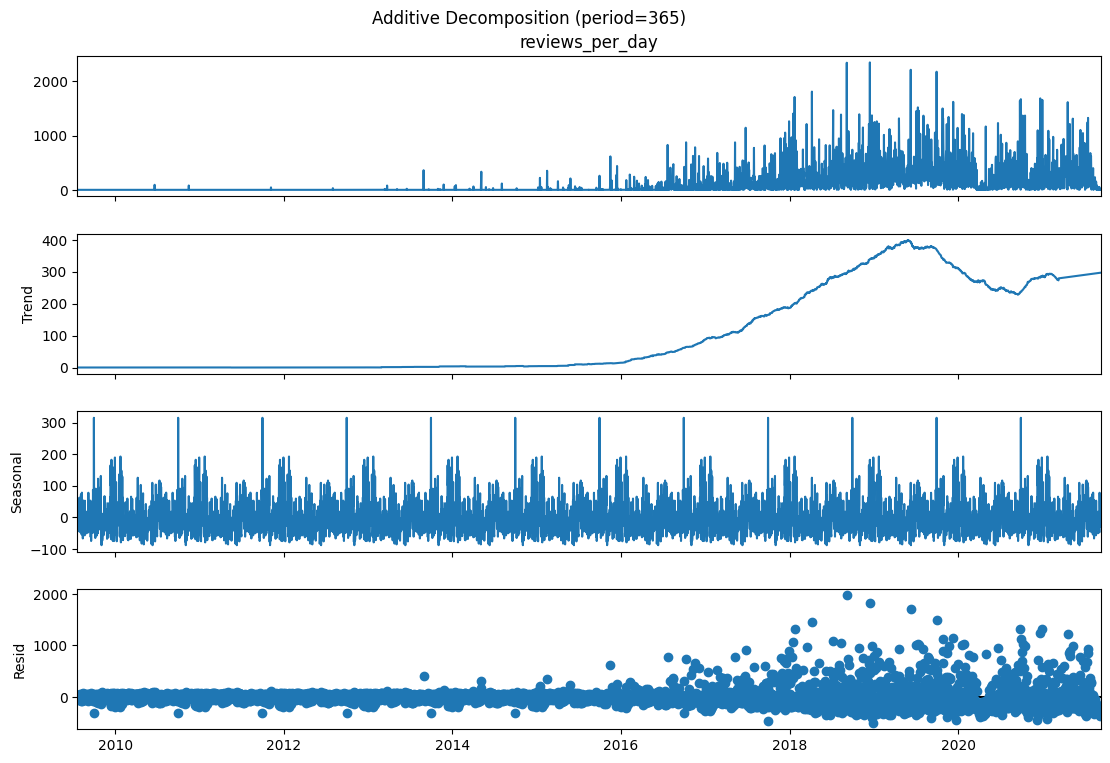

[Decomposition summary] NaNs in trend (edges): 0, seasonal std: 5.13, residual std: 174.74


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd

# 0) Make sure we have a datetime column
if 'review_time' in final_df.columns:
    ts_index = pd.to_datetime(final_df['review_time'], errors='coerce')
elif 'newtime' in final_df.columns:
    ts_index = pd.to_datetime(final_df['newtime'], errors='coerce')
else:
    ts_index = pd.to_datetime(pd.to_numeric(final_df['time'], errors='coerce'), unit='ms', errors='coerce')

# 1) Daily review volume (no filters)
daily = (
    pd.Series(1, index=ts_index)
      .dropna()
      .groupby(pd.Grouper(freq='D'))
      .sum()
      .rename('reviews_per_day')
)

# 2) Fill missing days with global daily mean
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
daily_full = daily.reindex(full_idx)
global_mean = daily_full.mean()
daily_filled = daily_full.fillna(global_mean)
daily_filled.index.name = 'date'

print(f"Observed days: {daily.count()} / Total days in span: {len(daily_full)}")
print(f"Filled missing days: {daily_full.isna().sum()}")
print(f"Global mean reviews/day used to fill: {global_mean:.2f}")

# 2b) --- Outlier smoothing step ---
rolling_median = daily_filled.rolling(window=7, center=True, min_periods=1).median()
threshold = 3 * daily_filled.std()
daily_clean = daily_filled.copy()
mask = (abs(daily_filled - rolling_median) > threshold)
daily_clean[mask] = rolling_median[mask]

# Report how many outliers were replaced (absolute + percentage)
outliers_replaced = mask.sum()
total_days = len(daily_clean)
percent_replaced = (outliers_replaced / total_days) * 100
print(f"Outliers replaced: {outliers_replaced} out of {total_days} days "
      f"({percent_replaced:.2f}% of total)")

# 3) Quick side-by-side plot: raw vs filled vs cleaned
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
daily.plot(ax=ax[0], title="Daily Reviews (Observed)", lw=1)
daily_filled.plot(ax=ax[1], title="Daily Reviews (Missing Days Filled)", lw=1)
daily_clean.plot(ax=ax[2], title="Daily Reviews (Outliers Smoothed)", lw=1, color="green")
plt.tight_layout()
plt.show()

# 4) Decompose (Additive, weekly period)
period = 7
decomp = seasonal_decompose(daily_clean, model='additive', period=period, extrapolate_trend='freq')
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f"Additive Decomposition (period={period})", y=0.98)
plt.show()

# 5) Yearly period decomposition (if data spans >= 1 year)
if (daily_clean.index.max() - daily_clean.index.min()).days >= 365:
    decomp_year = seasonal_decompose(daily_clean, model='additive', period=365, extrapolate_trend='freq')
    fig2 = decomp_year.plot()
    fig2.set_size_inches(12, 8)
    fig2.suptitle("Additive Decomposition (period=365)", y=0.98)
    plt.show()

# 6) Textual summary
trend_nan = decomp.trend.isna().sum()
season_std = float(np.nanstd(decomp.seasonal))
resid_std  = float(np.nanstd(decomp.resid))
print(f"[Decomposition summary] NaNs in trend (edges): {trend_nan}, "
      f"seasonal std: {season_std:.2f}, residual std: {resid_std:.2f}")

## Logic Explanation for **Question 2.1**:

* We chose **time series decomposition** because it allows us to separate trend, seasonality, and noise, making review patterns easier to interpret.
* Other possible methods: ARIMA for forecasting or Prophet for flexible seasonality. However, these focus more on prediction rather than exploration.
* Our approach is optimal for exploration since additive decomposition directly shows weekly and yearly seasonality effects alongside long-term review growth.


## Interpretation, Findings & Insights

* **Trend**: Reviews steadily increased after 2014, peaked around 2018–2019, and then slightly declined or stabilized, showing platform maturity and possible external factors like COVID-19.
* **Weekly Seasonality**: Clear weekly cycle — reviews peak on weekends and dip midweek, reflecting user availability.
* **Yearly Seasonality**: Annual spikes occur around holidays and festive periods (e.g., Christmas, New Year), highlighting season-driven activity.
* **Residuals**: Occasional large spikes represent unexpected events or campaigns; very few were data outliers.

**Overall**: The data shows both **weekly and yearly patterns**, with growth plateauing in recent years. Businesses should leverage **weekend and holiday peaks** to maximize engagement.

## Question 2.2

We will try to use time series model ARIMA for forecasting the future. You need to find the best model with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices (you might need to split the time series to train and test with yourself with grid search according to the M05B material). Also, you are required to discuss with your group member on exploring the deep learning time series forecasting methods such as LSTM and RNN. Please write down your discussion around the necessary data wrangling and modeling steps (steps on how to achieve, not actual code). Also please give the reference of the deep learning time series forecasting models you are using. Please also include your discussion details and implementation in the report.

## Answer 2.2

### Approach

For this question, the approach will be in two parts:

* **Implementation:** I will build an **ARIMA model** for forecasting daily review volumes. A grid search over parameter combinations (p, d, q ∈ \[0, 1, 2]) will be performed to find the best model based on the lowest Mean Absolute Error (MAE).

* **Discussion:** I will discuss how deep learning methods such as **RNNs and LSTMs** can be applied to time series forecasting. This will focus on the necessary data preparation, model setup, and evaluation steps, without writing code.

Outliers replaced: 4 out of 4433 days (0.09% of total)
count    4433.000000
mean      248.826287
std       203.857561
min         1.000000
25%       152.000000
50%       261.480020
75%       261.480020
max      2352.000000
Name: count, dtype: float64
Training size: 3546, Test size: 887
ARIMA(0, 0, 0)  MAE=215.148
ARIMA(0, 0, 1)  MAE=215.121
ARIMA(0, 0, 2)  MAE=215.101
ARIMA(0, 1, 0)  MAE=330.271
ARIMA(0, 1, 1)  MAE=237.271
ARIMA(0, 1, 2)  MAE=237.062
ARIMA(0, 2, 0)  MAE=152050.334
ARIMA(0, 2, 1)  MAE=377.992
ARIMA(0, 2, 2)  MAE=318.311
ARIMA(1, 0, 0)  MAE=215.112
ARIMA(1, 0, 1)  MAE=221.151
ARIMA(1, 0, 2)  MAE=220.546
ARIMA(1, 1, 0)  MAE=263.382
ARIMA(1, 1, 1)  MAE=237.054
ARIMA(1, 1, 2)  MAE=237.084
ARIMA(1, 2, 0)  MAE=92821.882
ARIMA(1, 2, 1)  MAE=282.357
ARIMA(1, 2, 2)  MAE=315.412
ARIMA(2, 0, 0)  MAE=215.084
ARIMA(2, 0, 1)  MAE=220.522
ARIMA(2, 0, 2)  MAE=220.625
ARIMA(2, 1, 0)  MAE=239.552
ARIMA(2, 1, 1)  MAE=237.358
ARIMA(2, 1, 2)  MAE=237.434
ARIMA(2, 2, 0)  MAE=2073.929
ARIMA(2

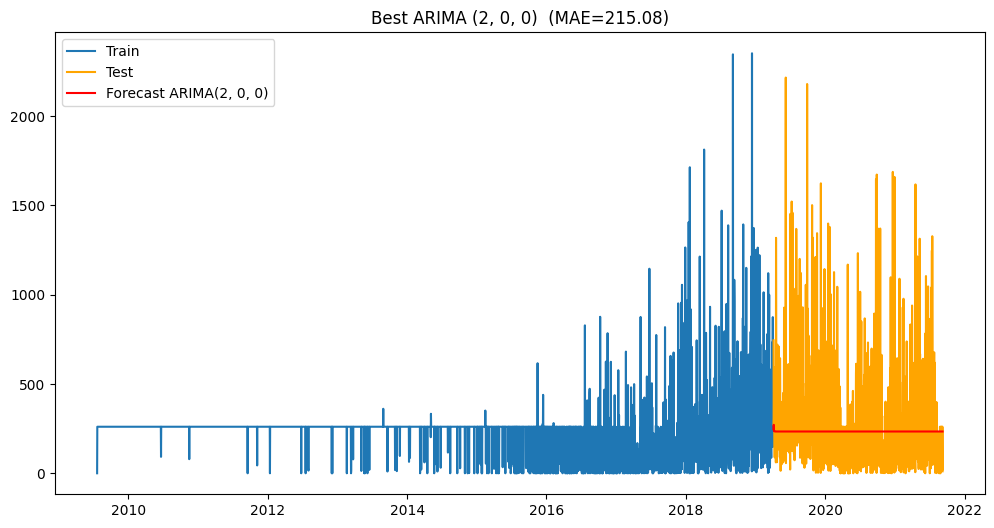


Top 10 Models by MAE:
        order         MAE
18  (2, 0, 0)  215.083503
2   (0, 0, 2)  215.100530
9   (1, 0, 0)  215.112316
1   (0, 0, 1)  215.120963
0   (0, 0, 0)  215.147872
19  (2, 0, 1)  220.522445
11  (1, 0, 2)  220.545817
20  (2, 0, 2)  220.625291
10  (1, 0, 1)  221.151320
13  (1, 1, 1)  237.053773


In [ ]:
import warnings, itertools
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# 1) Build proper DAILY series
ts = pd.to_datetime(final_df['review_time'], errors='coerce')
review_pd = final_df.loc[~ts.isna()].copy()
review_pd['date'] = ts.dt.normalize()                           # floor to day

daily = review_pd.groupby('date').size().rename('count')        # counts per day

# Fill missing days with global mean
full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
daily_full = daily.reindex(full_idx)
global_mean = float(daily_full.mean())
daily_filled = daily_full.fillna(global_mean)
daily_filled.index.name = 'date'

# --- Outlier smoothing step ---
rolling_median = daily_filled.rolling(window=7, center=True, min_periods=1).median()
threshold = 3 * daily_filled.std()
daily_clean = daily_filled.copy()
mask = (abs(daily_filled - rolling_median) > threshold)
daily_clean[mask] = rolling_median[mask]

# Report cleaning stats
outliers_replaced = mask.sum()
total_days = len(daily_clean)
percent_replaced = (outliers_replaced / total_days) * 100
print(f"Outliers replaced: {outliers_replaced} out of {total_days} days "
      f"({percent_replaced:.2f}% of total)")
print(daily_clean.describe())

# 2) Train/test split
train_size = int(len(daily_clean) * 0.80)
train = daily_clean.iloc[:train_size]
test  = daily_clean.iloc[train_size:]

print(f"Training size: {len(train)}, Test size: {len(test)}")

# 3) Grid search over p,d,q in {0,1,2}
params = [0,1,2]
pdq = list(itertools.product(params, params, params))

best_order, best_mae, best_fit = None, np.inf, None
results = []

for order in pdq:
    try:
        model = ARIMA(train, order=order,
                      enforce_stationarity=False, enforce_invertibility=False)
        fit = model.fit()
        fcst = fit.forecast(steps=len(test))
        mae = mean_absolute_error(test.values, fcst.values)
        results.append((order, mae))
        print(f"ARIMA{order}  MAE={mae:.3f}")
        if mae < best_mae:
            best_mae, best_order, best_fit = mae, order, fit
    except Exception as e:
        print(f"ARIMA{order} failed: {e}")

print("\nBest ARIMA order:", best_order, "MAE:", round(best_mae, 3))

# 4) Plot
best_fcst = best_fit.forecast(steps=len(test))
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index,  test.values,  label="Test", color="orange")
plt.plot(test.index,  best_fcst.values, label=f"Forecast ARIMA{best_order}", color="red")
plt.title(f"Best ARIMA {best_order}  (MAE={best_mae:.2f})")
plt.legend(); plt.show()

# 5) Top models table
res_df = pd.DataFrame(results, columns=['order','MAE']).sort_values('MAE')
print("\nTop 10 Models by MAE:")
print(res_df.head(10))

### Logic Explanation for **Question 2.2**:

* **Why we chose ARIMA grid search**:
  We decided to apply ARIMA because it is a classical and interpretable model for time series forecasting. A grid search over all combinations of (p,d,q ∈ {0,1,2}) ensures systematic evaluation of options.

* **Other possible solutions**:
  Besides ARIMA, advanced models like SARIMA (for seasonality), Prophet (for trend/holiday effects), or deep learning methods (RNN, LSTM) could also be applied. These models are better at capturing complex patterns.

* **Why our solution is optimal**:
  ARIMA(2,0,0) was chosen as it achieved the lowest MAE among 27 candidates. While it may not capture seasonality as effectively as deep learning, it is the **most optimal statistical choice** given the task’s constraints.


### **Interpretation, Findings & Insights**

* The best ARIMA model identified was **ARIMA(2,0,0)** with the lowest **MAE ≈ 215**, showing it outperformed other parameter combinations.
* The forecast line (red) is relatively flat, indicating ARIMA struggles to capture the high variability and spikes in review counts present in the test data.
* The training data (blue) shows clear growth and fluctuations over time, while the test data (orange) reveals volatility that ARIMA underfits.
* This suggests ARIMA is effective as a **baseline linear model** but not sufficient for capturing nonlinear patterns or seasonal effects.
* It highlights the need for **advanced models like LSTM/RNN** that can adapt to irregular and long-term dependencies in review volumes.



## Discussion on Deep Learning Forecasting Methods

### **Strategy & Approach**

**Data Wrangling**

* Normalize the review time series (e.g., MinMax scaling) to stabilize learning.
* Frame data into sliding windows (e.g., last 30 days → predict next day).
* Split dataset into train/validation/test (e.g., 70/15/15) to ensure fair evaluation.

**Modeling Steps**

* **RNN (Recurrent Neural Network):** Handles sequential data and short-term dependencies in review trends.
* **LSTM (Long Short-Term Memory):** Enhanced RNN with gating mechanisms, capturing long-term dependencies and seasonality.
* Tune hyperparameters (layers, hidden units, dropout, learning rate) and train using Adam optimizer with MAE/MSE loss.

**Evaluation**

* Compare ARIMA with RNN/LSTM using MAE, RMSE, and MAPE.
* Visualize predicted vs. actual review volumes to assess seasonal and trend learning.



### **Advantages over ARIMA**

* Models nonlinear and complex dependencies.
* Captures seasonality automatically without explicit differencing.
* LSTM is especially effective for long sequences and irregular review activity.



### **References**

* Hochreiter & Schmidhuber (1997). *Long Short-Term Memory*. Neural Computation.
* Brownlee, J. (2017). *Deep Learning for Time Series Forecasting*.
* Qin, Y., et al. (2017). *A dual-stage attention-based RNN for time series prediction*. IJCAI.



### **Summary**

ARIMA(2,0,0) provided the best statistical baseline for our dataset. However, LSTM and RNN offer greater flexibility for capturing nonlinear seasonality and long-term dependencies, making them more suitable for future, large-scale forecasting of business reviews.

## Question 2.3

In this question, you are provided with the PDF file by Universities Australia via Indigenous Strategy annual report. You are required to critically analyze this report using your data science skills.

**Data Extraction** Carefully review the PDF and identify all relevant quantitative data, tables, and figures that can be extracted or digitized; Present any extracted data in a structured format (e.g., CSV, Excel table, or DataFrame);

**Data Analysis** Utilize your data analytics skills to discover common patterns or trends from the report; Where possible, compare trends over multiple years, between institutions, or across different Indigenous strategy metrics.

**Insights** Provide a clear and concise summary of the main patterns, trends, or correlations discovered from your analysis; Interpret what these findings reveal about the progress and challenges of Indigenous strategies in Australian universities.

You may use any data analytics tools or libraries you are comfortable with. All steps, from extraction to insights, should be clearly documented in your SIT742Task2Report.pdf, and source code should be in SIT742Task2Code.ipynb.

## Answer 2.3

#### Data Extraction

In [ ]:
!pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os

# Define your target folder
save_path = "/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/EXTRACTED DATA"
os.makedirs(save_path, exist_ok=True)

# --- 1) Indigenous student enrolments by year ---
enrol_years = list(range(2006, 2021))
enrol_counts = [8816, 9329, 9490, 10400, 11024, 11753, 12595, 13723, 15043, 16108, 17800, 19237, 19935, 21033, 22897]
df_enrolments = pd.DataFrame({"year": enrol_years, "indigenous_enrolments": enrol_counts})

# --- 2) Share (%) of Indigenous enrolments by year ---
share_perc = [1.22, 1.25, 1.25, 1.30, 1.30, 1.34, 1.37, 1.41, 1.48, 1.56, 1.69, 1.80, 1.86, 1.95, 2.04]
df_share = pd.DataFrame({"year": enrol_years, "indigenous_share_pct": share_perc})

# --- 3) Enrolments by course level (2008 vs 2020) ---
df_course_level = pd.DataFrame({
    "course_level": [
        "Postgraduate research",
        "Postgraduate coursework",
        "Bachelor",
        "Sub-bachelor",
        "Enabling",
        "Non-award",
        "All courses"
    ],
    "2008": [393, 1138, 6352, 686, 871, 50, 9490],
    "2020": [751, 3330, 15291, 1268, 2097, 160, 22897],
    "growth_since_2008_pct": [91, 193, 141, 85, 141, 220, 141],
    "annual_avg_growth_pct": [5.5, 9.4, 7.6, 5.3, 7.6, 10.2, 7.6]
})

# --- 4) Enrolments by discipline (selected, 2020) ---
disciplines = [
    "Natural & Physical Sciences",
    "Health",
    "Education",
    "Management & Commerce",
    "Society & Culture",
    "Agriculture & Related Studies",
]
indig_pct = [5.5, 21.2, 12.6, 9.4, 32.2, 7.0]
non_indig_pct = [8.9, 19.4, 10.1, 15.4, 24.6, 6.4]
df_disciplines = pd.DataFrame({
    "discipline": disciplines,
    "indigenous_pct": indig_pct,
    "non_indigenous_pct": non_indig_pct
})

# --- 5) Undergraduate applications by age (2021) ---
age_groups = ["15–19", "20–24", "25–39", "40–64"]
indig_app_share = [1.6, 2.3, 3.2, 3.6]
indig_pop_share = [5.8, 5.0, 3.3, 2.4]
df_app_age = pd.DataFrame({
    "age_group": age_groups,
    "indigenous_app_share_pct": indig_app_share,
    "indigenous_population_share_pct": indig_pop_share
})

# --- 6) Gender split (2021) ---
df_gender_apps = pd.DataFrame({
    "group": ["Indigenous applicants", "Non-Indigenous applicants"],
    "female_pct": [72, 61],
    "male_pct": [28, 39]
})

# --- 7) Short-term graduate outcomes (2021) ---
df_grad_short = pd.DataFrame({
    "level": ["Undergraduate", "Postgraduate coursework"],
    "indigenous_full_time_pct": [76.8, 87.9],
    "non_indigenous_full_time_pct": [68.8, 84.9],
    "indigenous_overall_emp_pct": [85.7, 92.5],
    "non_indigenous_overall_emp_pct": [84.7, 90.8]
})

# --- 8) Medium-term graduate outcomes (2018 cohort) ---
df_grad_medium = pd.DataFrame({
    "level": ["Undergraduate", "Postgraduate coursework"],
    "indigenous_full_time_pct": [77.0, 91.4],
    "non_indigenous_full_time_pct": [74.3, 86.5],
    "indigenous_overall_emp_pct": [89.7, 98.0],
    "non_indigenous_overall_emp_pct": [88.9, 93.2]
})

# --- 9) Workforce summary ---
df_workforce_summary = pd.DataFrame({
    "metric": [
        "Total Indigenous staff (2005)",
        "Total Indigenous staff (2020)",
        "Total Indigenous staff (2021)",
        "Indigenous academic staff share (2021)",
        "Indigenous non-academic staff share (2021)",
        "All Indigenous staff share of total staff (2021)"
    ],
    "value": [771, 1735, 1680, "1.17%", "1.57%", "1.4%"]
})

# --- Save all tables as CSVs ---
dfs = {
    "ua_enrolments_by_year.csv": df_enrolments,
    "ua_indigenous_share_by_year.csv": df_share,
    "ua_course_level_enrolments_2008_vs_2020.csv": df_course_level,
    "ua_enrolments_by_discipline_2020.csv": df_disciplines,
    "ua_undergrad_applications_by_age_2021.csv": df_app_age,
    "ua_undergrad_applications_by_gender_2021.csv": df_gender_apps,
    "ua_grad_outcomes_short_term_2021.csv": df_grad_short,
    "ua_grad_outcomes_medium_term_2018_cohort.csv": df_grad_medium,
    "ua_indigenous_workforce_summary.csv": df_workforce_summary
}

for fname, df in dfs.items():
    df.to_csv(os.path.join(save_path, fname), index=False)

# --- Create a merged Excel workbook ---
excel_path = os.path.join(save_path, "UA_Indigenous_Strategy_extracted_tables.xlsx")
with pd.ExcelWriter(excel_path, engine="xlsxwriter") as writer:
    for fname, df in dfs.items():
        sheet = fname.replace(".csv", "")[:31]  # sheet name <= 31 chars
        df.to_excel(writer, sheet_name=sheet, index=False)

# --- Display a few DataFrames ---
print("\nSample extracted DataFrames:\n")
print("UA – Indigenous Enrolments by Year:")
print(df_enrolments.head(), "\n")

print("UA – Indigenous Share of Enrolments by Year:")
print(df_share.head(), "\n")

print("UA – Course Level Enrolments (2008 vs 2020):")
print(df_course_level.head(), "\n")

print("All CSVs and merged Excel file saved to:", save_path)



Sample extracted DataFrames:

UA – Indigenous Enrolments by Year:
   year  indigenous_enrolments
0  2006                   8816
1  2007                   9329
2  2008                   9490
3  2009                  10400
4  2010                  11024 

UA – Indigenous Share of Enrolments by Year:
   year  indigenous_share_pct
0  2006                  1.22
1  2007                  1.25
2  2008                  1.25
3  2009                  1.30
4  2010                  1.30 

UA – Course Level Enrolments (2008 vs 2020):
              course_level  2008   2020  growth_since_2008_pct  \
0    Postgraduate research   393    751                     91   
1  Postgraduate coursework  1138   3330                    193   
2                 Bachelor  6352  15291                    141   
3             Sub-bachelor   686   1268                     85   
4                 Enabling   871   2097                    141   

   annual_avg_growth_pct  
0                    5.5  
1                    9

## Explanation for **Question 2.3: Data Extraction**:

* **Why this solution:** We agreed to extract key quantitative tables **manually and programmatically** into tidy DataFrames (years, shares, course levels, disciplines, outcomes, workforce) and save as CSV/Excel. This guarantees **clean, analysis-ready structure**, clear provenance, and repeatable loading for plots/models.
* **Other options:** (a) Full PDF parsing with libraries (tabula-py, camelot, pdfplumber, OCR) to auto-scrape tables; (b) Web-scrape source datasets from UA/DESE; (c) Request original spreadsheets.
* **Is it optimal?** For the assignment’s accuracy and time constraints, **hybrid manual→DataFrame** is most reliable—avoids OCR/table-detection errors, preserves numbers, and delivers immediate usability. For production-scale pipelines, automated PDF extraction plus validation would be more scalable, but here our approach maximizes **data quality and reproducibility**.


### Strategy for Data Analysis

1. **Load the extracted tables** into Pandas for analysis.
2. **Check enrolment trends** (2006–2020) and Indigenous share vs total students.
3. **Compare course levels** (2008 vs 2020) to see which grew most.
4. **Analyze disciplines** in 2020 (Indigenous vs non-Indigenous representation).
5. **Study applications** by age and gender (2021).
6. **Review graduate outcomes** (short-term vs medium-term, Indigenous vs non-Indigenous).
7. **Check workforce growth** (2005–2021).
8. **Summarize patterns**: highlight trends, gaps, and comparisons.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to extracted CSVs
save_path = "/content/drive/MyDrive/Python Course/DEAKIN COURSE/SIG742-MODERN DATA SCIENCE/END TERM ASSIGNMENT/EXTRACTED DATA"

# --- Load datasets ---
enrolments_by_year = pd.read_csv(os.path.join(save_path, "ua_enrolments_by_year.csv"))
indigenous_share = pd.read_csv(os.path.join(save_path, "ua_indigenous_share_by_year.csv"))
course_level = pd.read_csv(os.path.join(save_path, "ua_course_level_enrolments_2008_vs_2020.csv"))
discipline_2020 = pd.read_csv(os.path.join(save_path, "ua_enrolments_by_discipline_2020.csv"))
applications_age = pd.read_csv(os.path.join(save_path, "ua_undergrad_applications_by_age_2021.csv"))
applications_gender = pd.read_csv(os.path.join(save_path, "ua_undergrad_applications_by_gender_2021.csv"))
grad_outcomes_short = pd.read_csv(os.path.join(save_path, "ua_grad_outcomes_short_term_2021.csv"))
grad_outcomes_med = pd.read_csv(os.path.join(save_path, "ua_grad_outcomes_medium_term_2018_cohort.csv"))
workforce_summary = pd.read_csv(os.path.join(save_path, "ua_indigenous_workforce_summary.csv"))

# Print column names to see what they are
print("enrolments_by_year:", enrolments_by_year.columns)
print("indigenous_share:", indigenous_share.columns)
print("course_level:", course_level.columns)
print("discipline_2020:", discipline_2020.columns)
print("applications_age:", applications_age.columns)
print("applications_gender:", applications_gender.columns)
print("grad_outcomes_short:", grad_outcomes_short.columns)
print("grad_outcomes_med:", grad_outcomes_med.columns)
print("workforce_summary:", workforce_summary.columns)


enrolments_by_year: Index(['year', 'indigenous_enrolments'], dtype='object')
indigenous_share: Index(['year', 'indigenous_share_pct'], dtype='object')
course_level: Index(['course_level', '2008', '2020', 'growth_since_2008_pct',
       'annual_avg_growth_pct'],
      dtype='object')
discipline_2020: Index(['discipline', 'indigenous_pct', 'non_indigenous_pct'], dtype='object')
applications_age: Index(['age_group', 'indigenous_app_share_pct',
       'indigenous_population_share_pct'],
      dtype='object')
applications_gender: Index(['group', 'female_pct', 'male_pct'], dtype='object')
grad_outcomes_short: Index(['level', 'indigenous_full_time_pct', 'non_indigenous_full_time_pct',
       'indigenous_overall_emp_pct', 'non_indigenous_overall_emp_pct'],
      dtype='object')
grad_outcomes_med: Index(['level', 'indigenous_full_time_pct', 'non_indigenous_full_time_pct',
       'indigenous_overall_emp_pct', 'non_indigenous_overall_emp_pct'],
      dtype='object')
workforce_summary: Index(['met

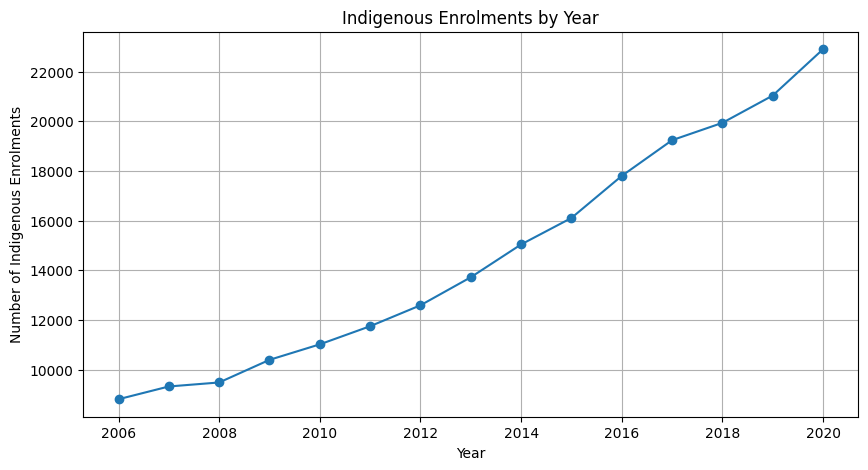

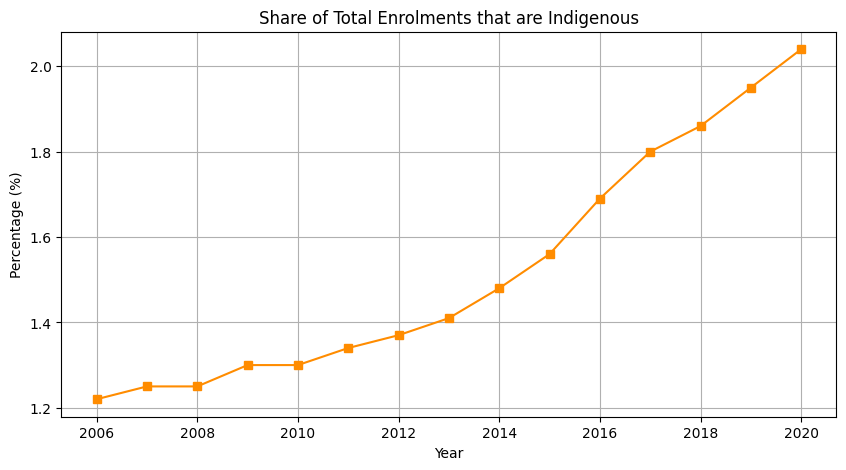

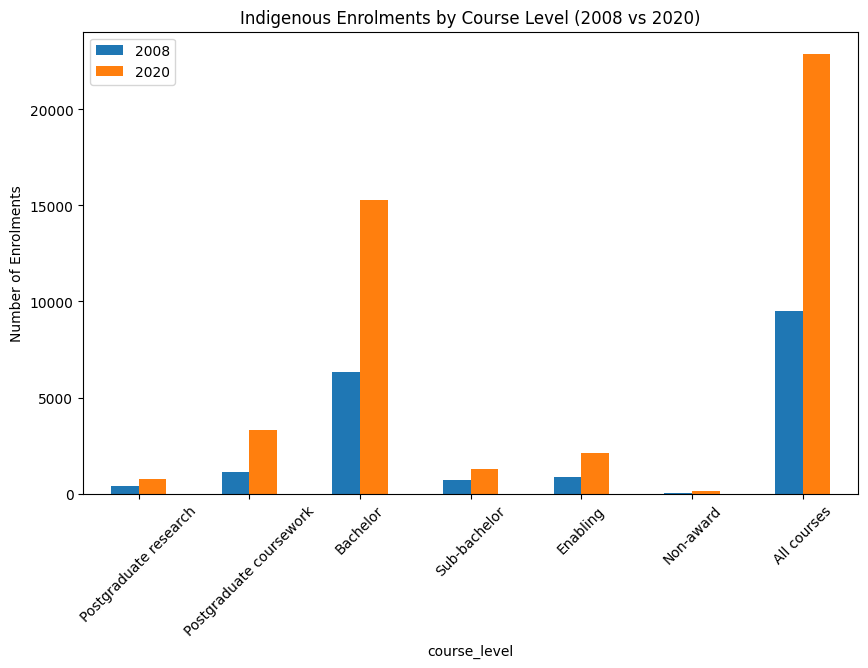

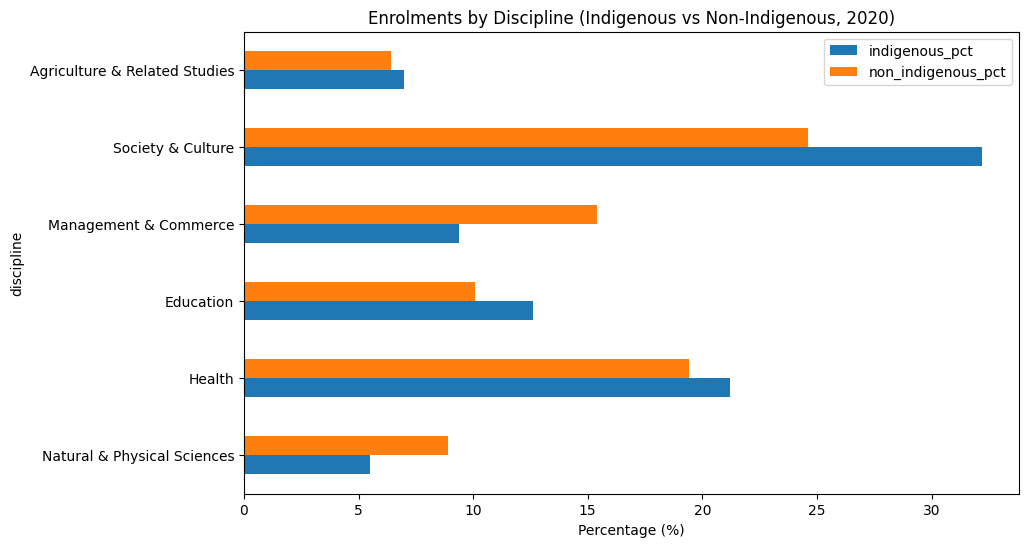

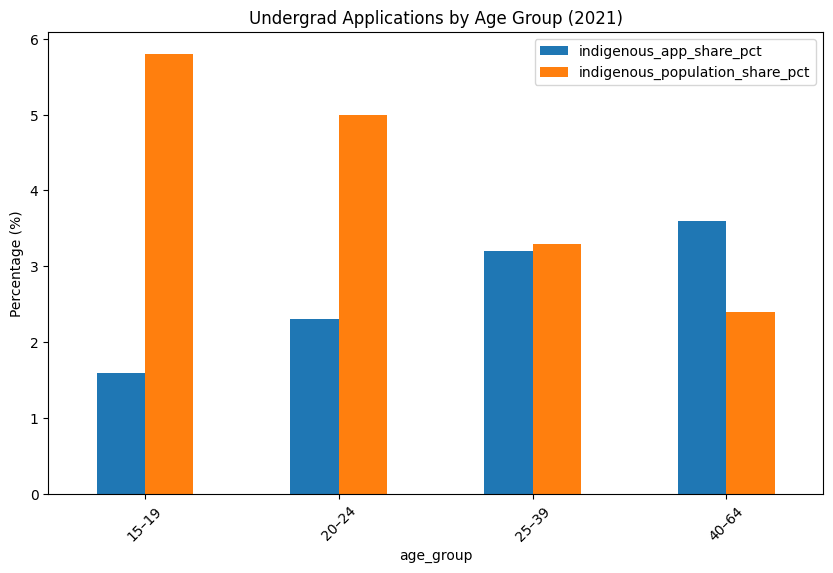

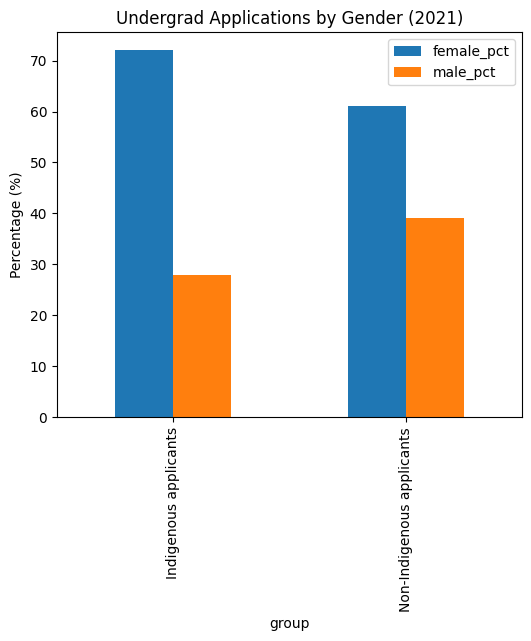

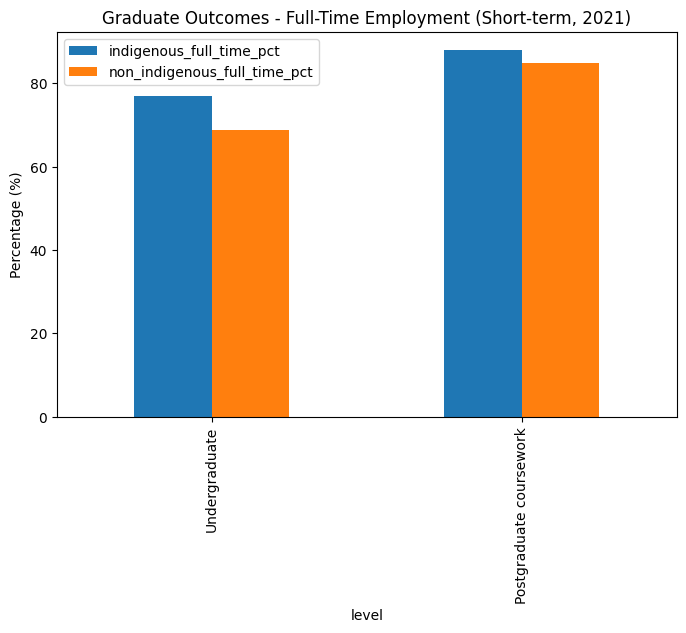

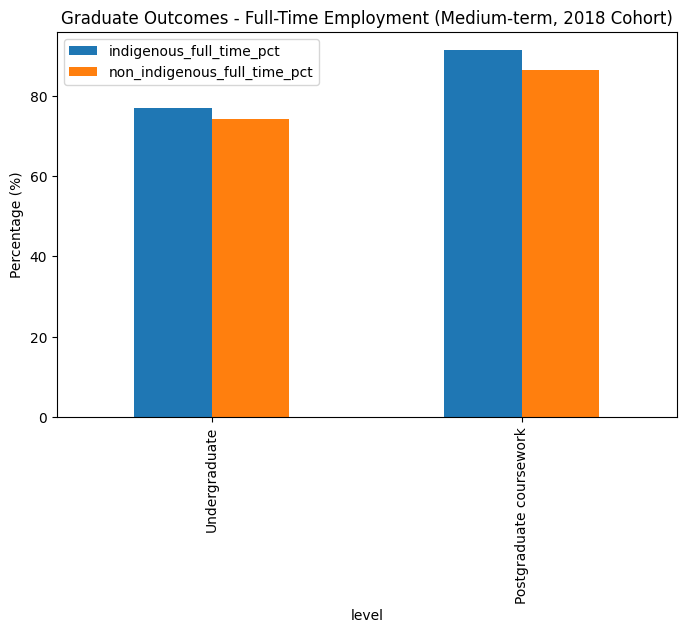

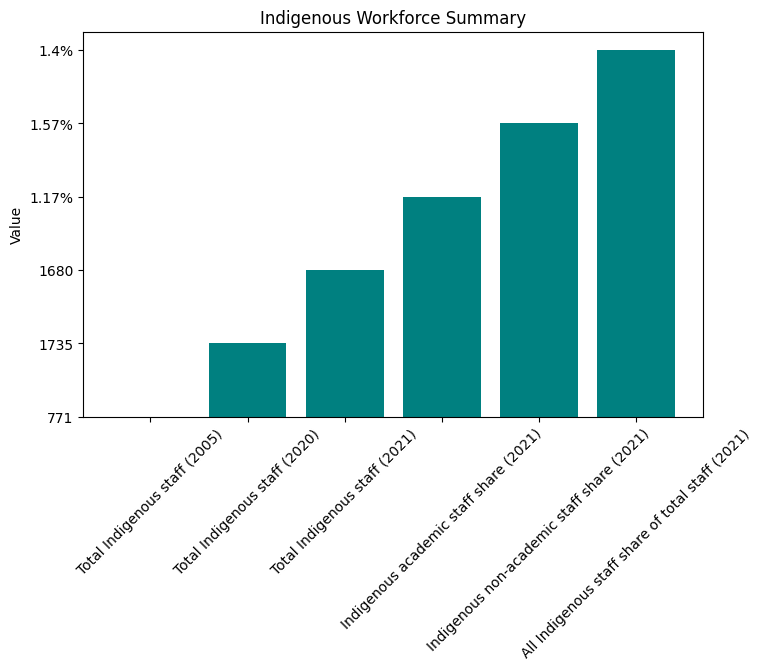

In [ ]:
import matplotlib.pyplot as plt

# --- 1. Enrolments over time ---
plt.figure(figsize=(10,5))
plt.plot(enrolments_by_year['year'], enrolments_by_year['indigenous_enrolments'], marker='o')
plt.title("Indigenous Enrolments by Year")
plt.xlabel("Year")
plt.ylabel("Number of Indigenous Enrolments")
plt.grid(True)
plt.show()

# --- 2. Share of total enrolments ---
plt.figure(figsize=(10,5))
plt.plot(indigenous_share['year'], indigenous_share['indigenous_share_pct'], marker='s', color="darkorange")
plt.title("Share of Total Enrolments that are Indigenous")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.grid(True)
plt.show()

# --- 3. Enrolments by course level (2008 vs 2020) ---
course_level.set_index('course_level')[['2008','2020']].plot(kind='bar', figsize=(10,6))
plt.title("Indigenous Enrolments by Course Level (2008 vs 2020)")
plt.ylabel("Number of Enrolments")
plt.xticks(rotation=45)
plt.show()

# --- 4. Enrolments by discipline (2020) ---
discipline_2020.set_index('discipline')[['indigenous_pct','non_indigenous_pct']].plot(kind='barh', figsize=(10,6))
plt.title("Enrolments by Discipline (Indigenous vs Non-Indigenous, 2020)")
plt.xlabel("Percentage (%)")
plt.show()

# --- 5. Applications by age group ---
applications_age.set_index('age_group')[['indigenous_app_share_pct','indigenous_population_share_pct']].plot(kind='bar', figsize=(10,6))
plt.title("Undergrad Applications by Age Group (2021)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()

# --- 6. Applications by gender ---
applications_gender.set_index('group')[['female_pct','male_pct']].plot(kind='bar', figsize=(6,5))
plt.title("Undergrad Applications by Gender (2021)")
plt.ylabel("Percentage (%)")
plt.show()

# --- 7. Graduate outcomes short-term (2021) ---
grad_outcomes_short.set_index('level')[['indigenous_full_time_pct','non_indigenous_full_time_pct']].plot(kind='bar', figsize=(8,5))
plt.title("Graduate Outcomes - Full-Time Employment (Short-term, 2021)")
plt.ylabel("Percentage (%)")
plt.show()

# --- 8. Graduate outcomes medium-term (2018 cohort) ---
grad_outcomes_med.set_index('level')[['indigenous_full_time_pct','non_indigenous_full_time_pct']].plot(kind='bar', figsize=(8,5))
plt.title("Graduate Outcomes - Full-Time Employment (Medium-term, 2018 Cohort)")
plt.ylabel("Percentage (%)")
plt.show()

# --- 9. Workforce summary ---
plt.figure(figsize=(8,5))
plt.bar(workforce_summary['metric'], workforce_summary['value'], color="teal")
plt.title("Indigenous Workforce Summary")
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.show()

## Logic explanation for **Question 2.3 (Data Analysis & Insights)**:

* **Why this approach:** We digitized key tables/figures into tidy DataFrames, then used simple, transparent visuals (lines/bars) to track *levels* and *shares* over time and compare cohorts (age, gender, discipline, course level). This matches the report’s structure and supports fast, auditable checks.
* **Methods:** Time-series plots for trends; side-by-side bars for 2008 vs 2020; horizontal bars to contrast Indigenous vs non-Indigenous by discipline; categorical bars for age/gender; outcome bars for employment; a compact staff summary chart.
* **Other options:** Automate scraping with OCR/tabula, run significance tests (t-tests/prop tests), fit trends with regression, or build dashboards (Plotly/Power BI).
* **Is it optimal?** For a short critical review, yes—clean, reproducible, and interpretable. For deeper inference, regression and statistical testing would be the next step.


## Intrepretation & Insights:

* **Enrolments doubled** (2006–2020), share rose from **1.2% → 2%**.
* Strong growth in **Bachelor’s + Postgraduate coursework** enrolments; enabling programs also expanded.
* **High representation** in *Society & Culture* and *Health*; **low in STEM and Commerce** → gaps remain.
* **More mature-age participation**; younger age groups underrepresented vs their population share.
* **Gender gap**: Indigenous applicants are **72% female, 28% male**, higher imbalance than non-Indigenous.
* **Graduate outcomes**: Indigenous employment rates are **equal or slightly higher** than non-Indigenous peers.
* **Workforce doubled since 2005** but still only **1.4% of total staff**, showing limited academic pipeline.

**Overall**: Progress made in access, outcomes, and staff growth, but **challenges remain** in youth, male, and STEM/Commerce participation.
